In [1]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


df = pd.read_pickle('dataset/train_dataset.pkl')

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

<font size ="6"> Process-aware ML Based Intrusion Detection for Industrial Control Systems </font>

# Useful function

In [11]:
def get_train_test_dataset(df):
    split_date = '2015-12-28 10:00:00'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()
    return data_train, data_test

In [4]:
df_cols = pd.read_pickle('dataset/train_dataset.pkl')

cols_numeric = list(df_cols.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')
cols_numeric.remove('Normal/Attack')

cols_discrete = []
cols_continuous = []
for col in cols_numeric:
    if len(df_cols[col].unique()) > 5:
        cols_continuous.append(col)
    else:
        cols_discrete.append(col)

In [18]:
attack_df = pd.read_csv('attacks_df.csv')
attack_df['start_time'] = pd.to_datetime(attack_df['start_time'])
attack_df['end_time'] = pd.to_datetime(attack_df['end_time'])

def get_timestamp_attack(index_attack, offset):
    index_attack = attack_df[attack_df['num_attack'] == index_attack].index[0]
    index_start = df[df['Timestamp'] == attack_df.iloc[index_attack]['start_time']].index[0] - offset
    if offset + df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0] > len(df):
        offset = len(df) - df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0]
    index_end = df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0] + offset
    return index_start, index_end

In [19]:

def get_index_attack(attack_name):
    list_attack_index = []
    for i, attack in zip(attack_df['num_attack'], attack_df['attack_point']):
        attack = attack.replace('-', '')
        if attack_name in attack:
            list_attack_index.append(i)
    return list_attack_index

In [262]:
def get_moving_median(df, col, n):
    median_moving = []
    for i in range(0, len(df) - n, n):
        med = np.median(df.iloc[i:i+n][col])
        for j in range(n):
            median_moving.append(med)
    for j in range(19):
            median_moving.append(med)
    df_median_moving = pd.DataFrame(median_moving, columns=['median_moving'])
    return df_median_moving


def get_null(df, n):
    diff = np.diff(df['median_moving'])
    arr_diff = pd.DataFrame(diff, columns=['diff'])
    arr = pd.DataFrame( arr_diff[(arr_diff['diff'] <= 2) | (arr_diff['diff'] >= -2)] ).astype(dtype='int')
    
    up_down = []
    accumulator = 0
    for i in range(n-1, len(arr), n):
        ar = arr.iloc[i].values
        accumulator = 0 if ar != 0 else accumulator + 1
        for j in range(0, n):
            up_down.append(accumulator)
    for j in range(19):
        up_down.append(accumulator)
    return pd.DataFrame(up_down, columns=['null'])


def get_up_down(df, sign, n):
    arr = pd.DataFrame(sign * np.diff(df['median_moving']) >= sign * -2).astype(dtype='int')

    up_down = []
    accumulator = 0
    for i in range(n-1, len(arr), n):
        ar = arr.iloc[i].values
        if ar <= 0:
            accumulator = 0
        elif ar > 0:
            accumulator += sign
            
        for j in range(0, n):
            up_down.append(accumulator)
        
    for j in range(19):
        up_down.append(accumulator)
    return pd.DataFrame(up_down, columns=['up_down'])

def get_up_down_one(df, n):
    up = get_up_down(df, 1, n)
    down = get_up_down(df, -1, n)
    return pd.DataFrame(up['up_down'] + down['up_down'], columns=['up_down'])


# Feature Detection

In [12]:
train, test = get_train_test_dataset(df)

In [230]:
# Interquartile Range
def IQR_keep(df, col):

    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1

    # Above Upper bound
    upper = df[col] >= (Q3+1.5*IQR)

    # Below Lower bound
    lower = df[col] <= (Q1-1.5*IQR)

    keep = ~upper & ~lower
    return Q1, Q3, IQR, keep

## Detection of discrete constant and not constant feature

In [13]:
df_var_zero_mean = pd.DataFrame(columns=['col', 'mean'])

cols_var_zero_discrete = []
cols_not_var_zero_discrete = []
for col in cols_discrete:
    if np.var(train[col]) != 0:
        
        Q1, Q3, IQR, keep = IQR_keep(train, col)
        data = train[keep][col]
        if np.var(data) != 0:
            cols_not_var_zero_discrete.append(col)
        else:
            cols_var_zero_discrete.append(col)
            df_var_zero_mean = pd.concat(objs=[df_var_zero_mean, pd.DataFrame({'col': [col], 'mean': [data.mean()]})], axis=0, ignore_index=True)
    else:
        cols_var_zero_discrete.append(col)
        df_var_zero_mean = pd.concat(objs=[df_var_zero_mean, pd.DataFrame({'col': [col], 'mean': [train[col].mean()]})], axis=0, ignore_index=True)

## Detection of cylic & acyclic feature

In [ ]:
df_autocorrelation = pd.DataFrame()

for i, col in enumerate(cols_continuous):
    list_corr = []
    for LAG in range(1, int(len(train) / 2), 100):
        delay_coordinates = get_delay_embedding(f'{col}', LAG)
        corr = np.corrcoef([delay_coordinates[0], delay_coordinates[1]])[0, 1]
        list_corr.append(corr)
    
    corr_df = pd.DataFrame(list_corr, columns=['corr'])
    corr_df['lag'] = (corr_df.index + 1) * 1000
    
    df_autocorrelation = pd.concat([df_autocorrelation, corr_df['corr']], axis=1)

# ~4min

In [ ]:
df_autocorrelation.columns = cols_continuous
df_metric_auto = df_autocorrelation.describe()
df_metric_auto = df_metric_auto.T

In [239]:
# cols_cyclic = list(df_metric_auto[df_metric_auto['mean'] <= 1/100].index)
cols_cyclic = ['FIT101', 'LIT101', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'LIT401', 'FIT601']

In [226]:
# cols_acyclic = list(df_metric_auto[df_metric_auto['mean'] > 1/100].index)
cols_acyclic = [col for col in cols_continuous if col not in cols_cyclic]

In [15]:
len(cols_var_zero_discrete), len(cols_not_var_zero_discrete), len(cols_cyclic), len(cols_acyclic)

(8, 12, 8, 17)

In [17]:
len(cols_var_zero_discrete)+ len(cols_not_var_zero_discrete)+ len(cols_cyclic)+ len(cols_acyclic)

37

# Models

## Min-Max Model

In [240]:
model_continuous_feature_check = pd.DataFrame(columns=['col', 'min', 'max'])

for col in cols_cyclic:
    col_df = pd.DataFrame({
        'col': [col],
        'min': [train[col].min()],
        'max': [train[col].max()]
    })
    model_continuous_feature_check = pd.concat(objs=[model_continuous_feature_check, col_df], axis=0, ignore_index=True)

model_continuous_feature_check

col       min          max
0   FIT101    0.0000     2.745092
1   LIT101  486.3809   817.556500
2   FIT201    0.0000     2.487938
3  DPIT301    0.0000    20.555090
4   FIT301    0.0000     2.358774
5   LIT301  785.1353  1014.724000
6   LIT401  774.3399  1003.935000
7   FIT601    0.0000     1.746131

In [21]:
def check_anomaly(df, col):
    df[f'anomaly_{col}'] = 0
    min = model_continuous_feature_check[model_continuous_feature_check['col'] == col]['min'].values[0]
    max = model_continuous_feature_check[model_continuous_feature_check['col'] == col]['max'].values[0]
    df.loc[(df[col] < min) | (df[col] > max), f'anomaly_{col}'] = 1
    return df

In [296]:
df_cyclic = df[cols_cyclic+['Normal/Attack', 'attack', 'Timestamp']].copy()
df_cyclic['Normal/Attack_int'] = df_cyclic['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)

for col in cols_cyclic:
    df_cyclic = check_anomaly(df_cyclic, col)

df_cyclic['min_max_anomaly'] = False
for col in cols_cyclic:
    df_cyclic['min_max_anomaly'] |= df_cyclic[f'anomaly_{col}'].astype(bool)

### Example of Min-Max model Detection

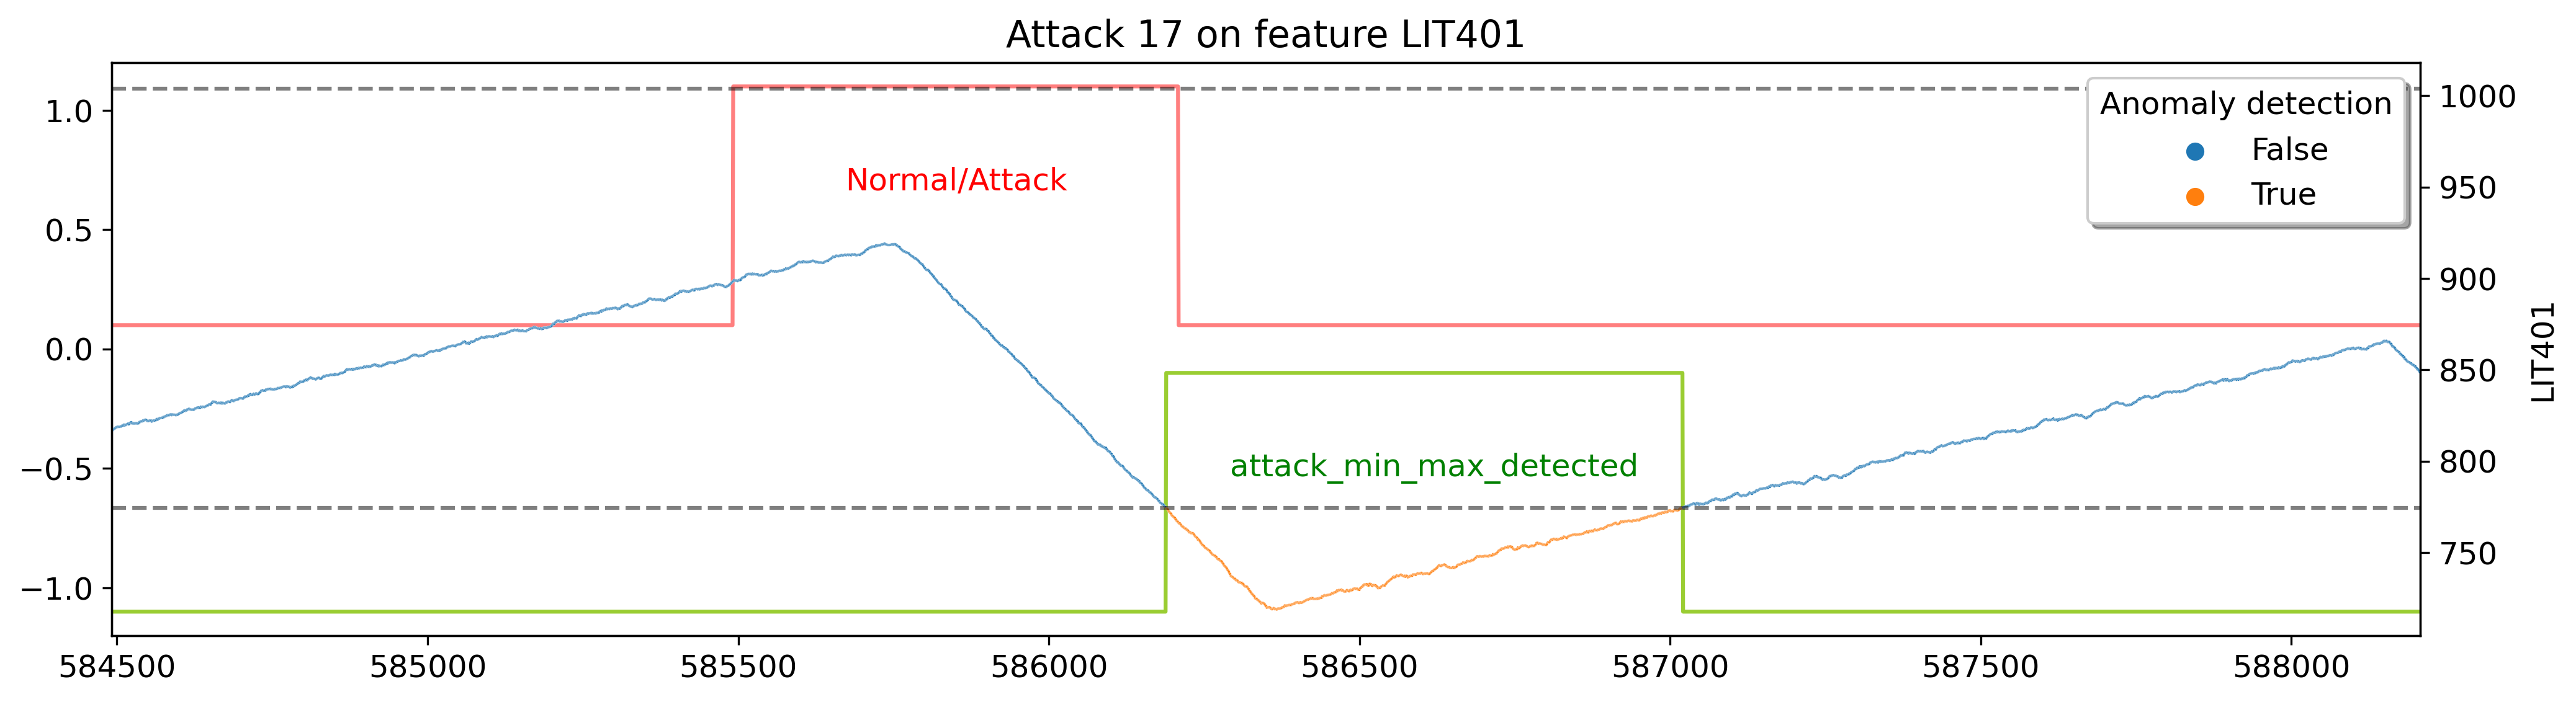

In [351]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4), dpi=300)

col = 'LIT401'
min_ = train[col].min()
max_ = train[col].max()

index_min, index_max = get_timestamp_attack(index_attack=17, offset=2000)
index_min+= 1000
ax.text(index_min + 1800, -0.5, f'attack_min_max_detected', horizontalalignment='left', verticalalignment='center', color='green')
ax.plot(df_cyclic.iloc[index_min:index_max]['min_max_anomaly'] - 1.1, color='yellowgreen', alpha=1)


ax.text(index_min + 1180, 0.7, f'Normal/Attack', horizontalalignment='left', verticalalignment='center', color='red')
ax.plot(df_cyclic['Normal/Attack_int'][index_min:index_max] + 0.1, color='red', alpha=0.5)

ax1 = ax.twinx()
data = df[col][index_min:index_max].to_frame()
data['anomaly_detection'] = False
data.loc[data['LIT401'] < min_, 'anomaly_detection'] = True

sns.scatterplot(data=data, x=data.index, y=data['LIT401'], hue=data['anomaly_detection'], ax=ax1, s=1)
# ax1.plot(data, color='blue', alpha=0.5)
ax1.axhline(y=min_, color='black', alpha=0.5, linestyle='--')
ax1.axhline(y=max_, color='black', alpha=0.5, linestyle='--')

ax.set_ylim(-1.2, 1.2)
ax.set_xlim(index_min, index_max)

ax.set_title(f'Attack 17 on feature {col}')
ax1.legend(loc='upper right', ncol=1, shadow=True, title='Anomaly detection')

fig.savefig('attack_with_after_effect.pdf', bbox_inches='tight')

### Accuracy 

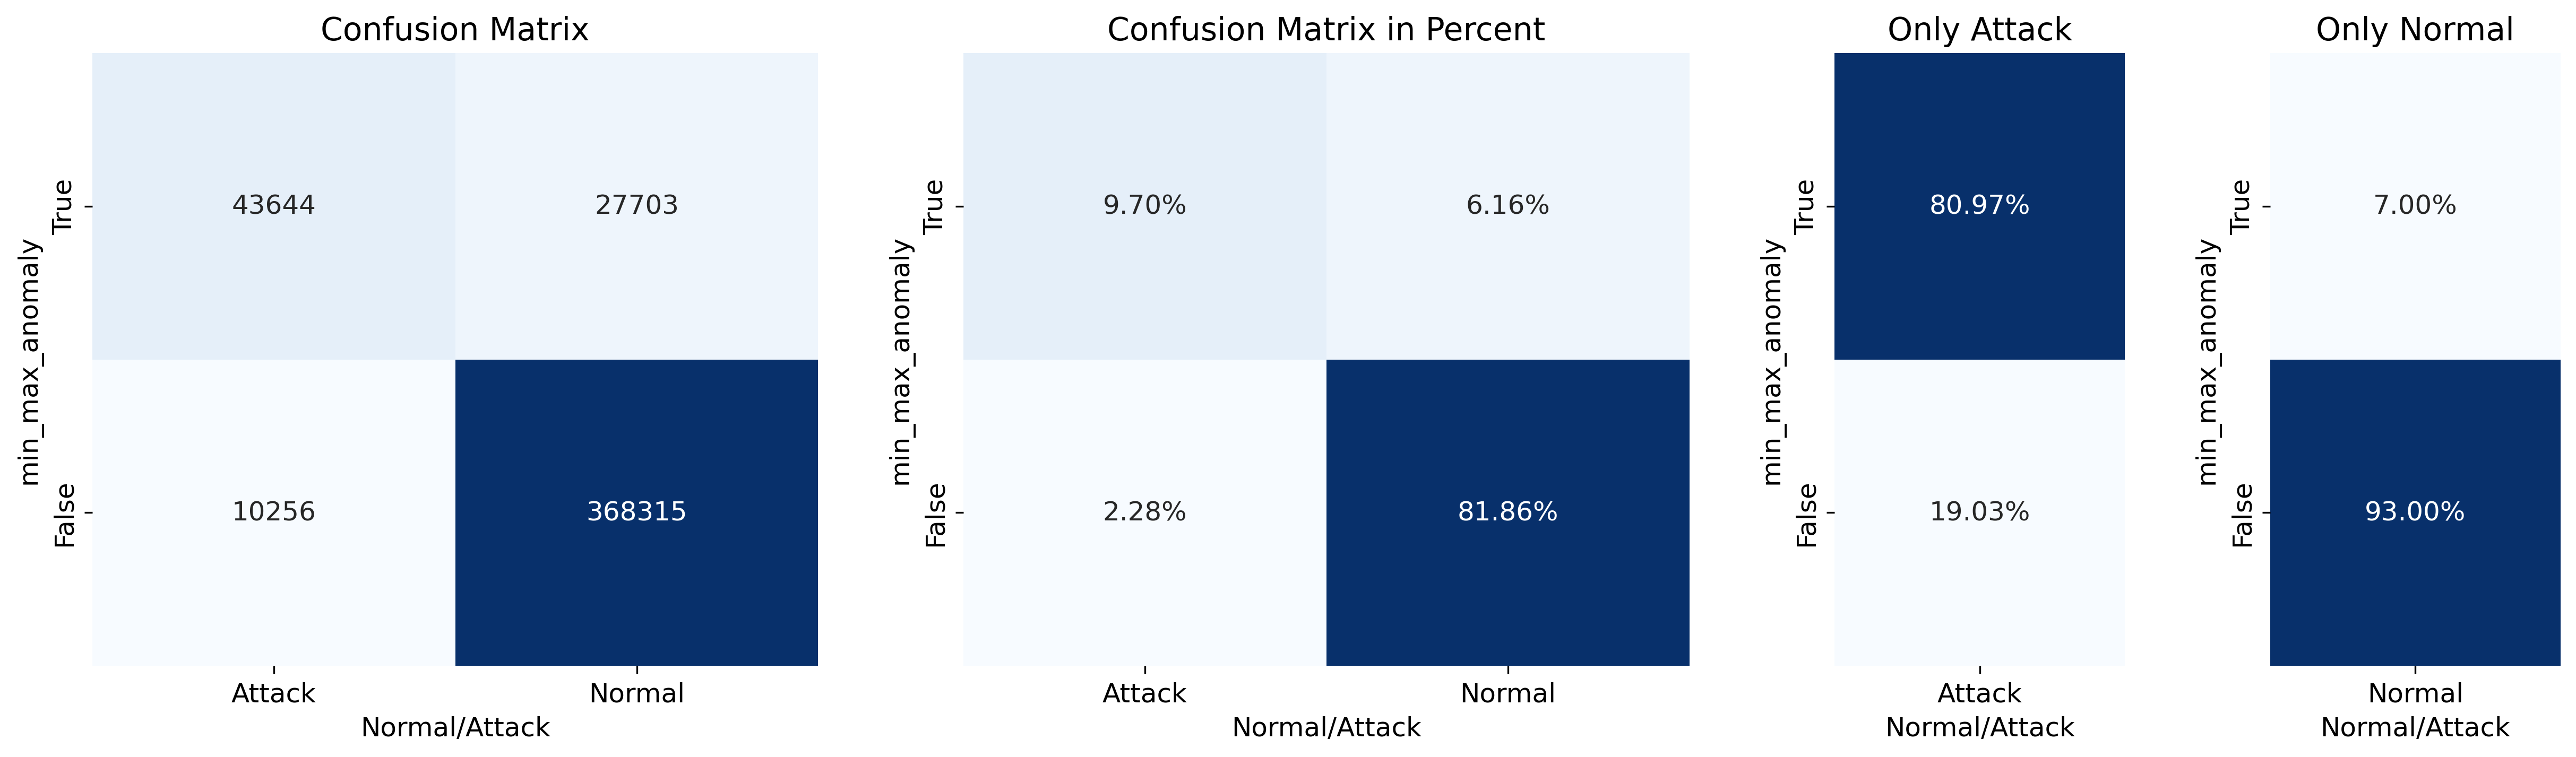

In [246]:
# create a heatmap of the min_max_anomaly and Normal/Attack
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)
# fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=300) 

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['min_max_anomaly', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['min_max_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['min_max_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['min_max_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)


In [308]:
from sklearn.metrics import classification_report, confusion_matrix
data = pd.DataFrame()
for col in cols_cyclic:
    labels = ['Normal', 'Attack']
    class_report = classification_report(df_cyclic_test['Normal/Attack_int'], df_cyclic_test[f'anomaly_{col}'], target_names=labels, output_dict=True)
    cm = confusion_matrix(df_cyclic_test['Normal/Attack_int'], df_cyclic_test[f'anomaly_{col}'])
    data = pd.concat([data, pd.DataFrame({
        'col': col, 
        'precision_attack': class_report['Attack']['precision'], 
        'precision_normal': class_report['Normal']['precision'], 
        'recall_attack': class_report['Attack']['recall'], 
        'recall_normal': class_report['Normal']['recall'], 
        'f1-score_attack': class_report['Attack']['f1-score'], 
        'f1-score_normal': class_report['Normal']['f1-score'], 
        'count_anomaly': df_cyclic_test[df_cyclic_test[f'anomaly_{col}'] == 1].shape[0],
        'count_normal': df_cyclic_test[df_cyclic_test[f'anomaly_{col}'] == 0].shape[0],
        'attack_well_detected': cm[1][1],
        'normal_well_detected': cm[0][0],
    }, index=[0])], axis=0)

data['attack_wrong_detected'] = data['count_anomaly'] - data['attack_well_detected']
data['normal_wrong_detected'] = data['count_normal'] - data['normal_well_detected']

data.index = data['col']
data = data.sort_values(by='count_anomaly', ascending=False)

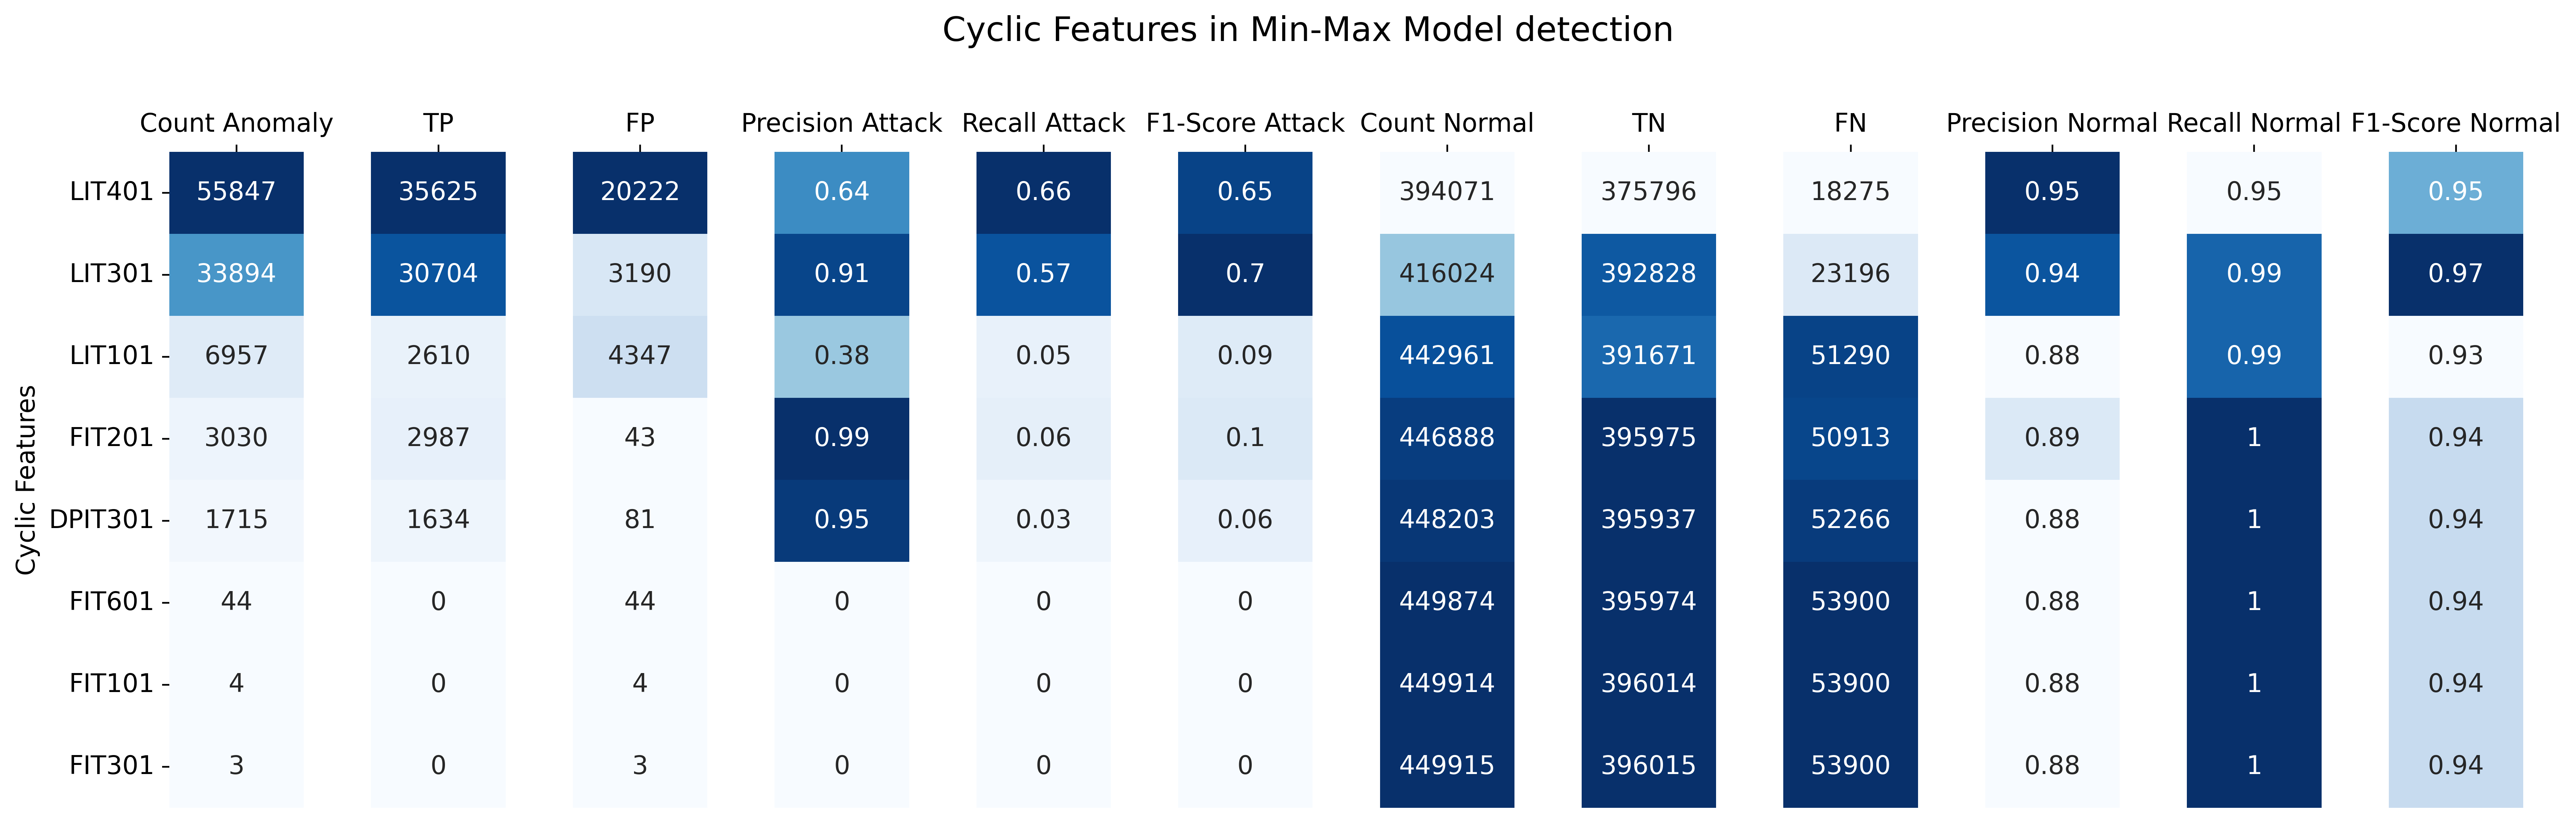

In [322]:
fig = plt.figure(figsize=(20, 6), dpi=400)

fig.suptitle('Cyclic Features in Min-Max Model detection', fontsize=16)

fig.subplots_adjust(top=0.83)

plt.rcParams.update({'font.size': 12})

gs = fig.add_gridspec(1, 12)

cols_keep = ['count_anomaly', 'attack_well_detected', 'attack_wrong_detected', 'precision_attack', 'recall_attack', 'f1-score_attack', 
             'count_normal', 'normal_well_detected', 'normal_wrong_detected', 'precision_normal', 'recall_normal', 'f1-score_normal', ]
cols_name = ['Count Anomaly', 'TP', 'FP', 'Precision Attack', 'Recall Attack', 'F1-Score Attack',
                'Count Normal', 'TN', 'FN', 'Precision Normal', 'Recall Normal', 'F1-Score Normal']

# add a subplot to the figure with 1 row and 1 column
ax1 = fig.add_subplot(gs[0, 0:1])
sns.heatmap(pd.DataFrame(data[cols_keep[0]]), annot=True, fmt="g", ax=ax1, cmap='Blues', cbar=False)
ax1.xaxis.tick_top()
ax1.set_xticklabels([cols_name[0]])
ax1.set_ylabel('Cyclic Features')

for i in range(1, 12):
    ax2 = fig.add_subplot(gs[0, i:i+1])
    sns.heatmap(pd.DataFrame(np.round(data[cols_keep[i]], 2)), annot=True, fmt="g", ax=ax2, cmap='Blues', cbar=False)
    ax2.xaxis.tick_top()
    ax2.set_xticklabels([cols_name[i]])
    ax2.set_ylabel('')
    ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.5)

fig.savefig('cyclic_features_min_max.pdf', bbox_inches='tight')

## Variance Zero Model

In [252]:
df_var_zero = df[cols_var_zero_discrete+['Normal/Attack', 'Timestamp']].copy()
df_var_zero['anomaly_var_zero'] = False

for col in cols_var_zero_discrete:
   
    df_var_zero[f'anomaly_var_zero_{col}'] = df_var_zero[col] != df_var_zero_mean[df_var_zero_mean['col'] == col]['mean'].values[0]
    
    df_var_zero['anomaly_var_zero'] |= df_var_zero[f'anomaly_var_zero_{col}']
        
df_var_zero_train, df_var_zero_test = get_train_test_dataset(df_var_zero)

In [323]:
df_cyclic['anomaly_var_zero'] = df_var_zero['anomaly_var_zero']

### Accuracy

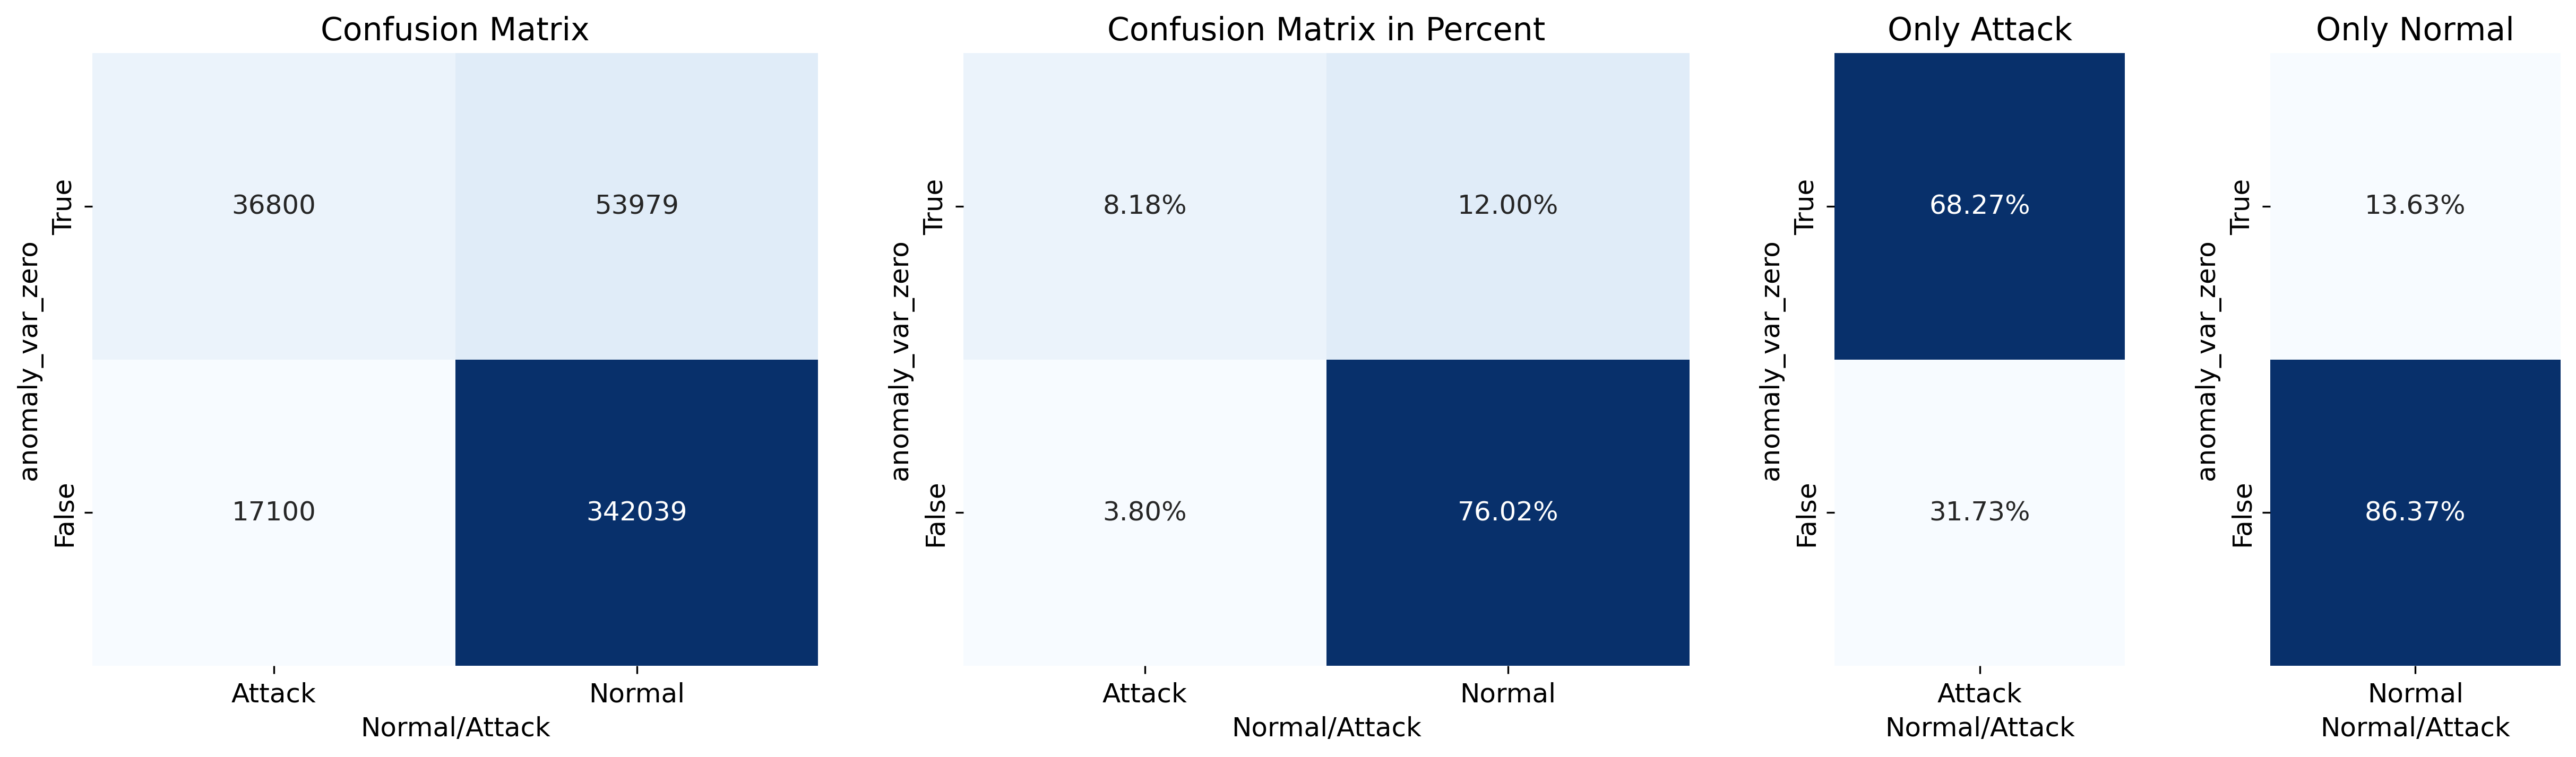

In [254]:
# create a heatmap of the min_max_anomaly and Normal/Attack
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)
# fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=300) 

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['anomaly_var_zero', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['anomaly_var_zero', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['anomaly_var_zero', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['anomaly_var_zero', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)


In [326]:
df_var_zero_test['Normal/Attack_int'] = df_var_zero_test['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)

data_var_zero = pd.DataFrame()
for col in cols_var_zero_discrete:
    # class_report = classification_report(df_cyclic_test['Normal/Attack_int'], df_cyclic_test[f'anomaly_{col}'], output_dict=True)
    labels = ['Normal', 'Attack']
    class_report = classification_report(df_var_zero_test['Normal/Attack_int'], df_var_zero_test[f'anomaly_var_zero_{col}'], target_names=labels, output_dict=True)
    cm = confusion_matrix(df_cyclic_test['Normal/Attack_int'], df_var_zero_test[f'anomaly_var_zero_{col}'])
    data_var_zero = pd.concat([data_var_zero, pd.DataFrame({
        'col': col, 
        'precision_attack': class_report['Attack']['precision'], 
        'precision_normal': class_report['Normal']['precision'], 
        'recall_attack': class_report['Attack']['recall'], 
        'recall_normal': class_report['Normal']['recall'], 
        'f1-score_attack': class_report['Attack']['f1-score'], 
        'f1-score_normal': class_report['Normal']['f1-score'], 
        'count_anomaly': df_var_zero_test[df_var_zero_test[f'anomaly_var_zero_{col}'] == 1].shape[0],
        'count_normal': df_var_zero_test[df_var_zero_test[f'anomaly_var_zero_{col}'] == 0].shape[0],
        'attack_well_detected': cm[1][1],
        'normal_well_detected': cm[0][0],
    }, index=[0])], axis=0)

data_var_zero['attack_wrong_detected'] = data_var_zero['count_anomaly'] - data_var_zero['attack_well_detected']
data_var_zero['normal_wrong_detected'] = data_var_zero['count_normal'] - data_var_zero['normal_well_detected']

data_var_zero.index = data_var_zero['col']
data_var_zero = data_var_zero.sort_values(by='count_anomaly', ascending=False)

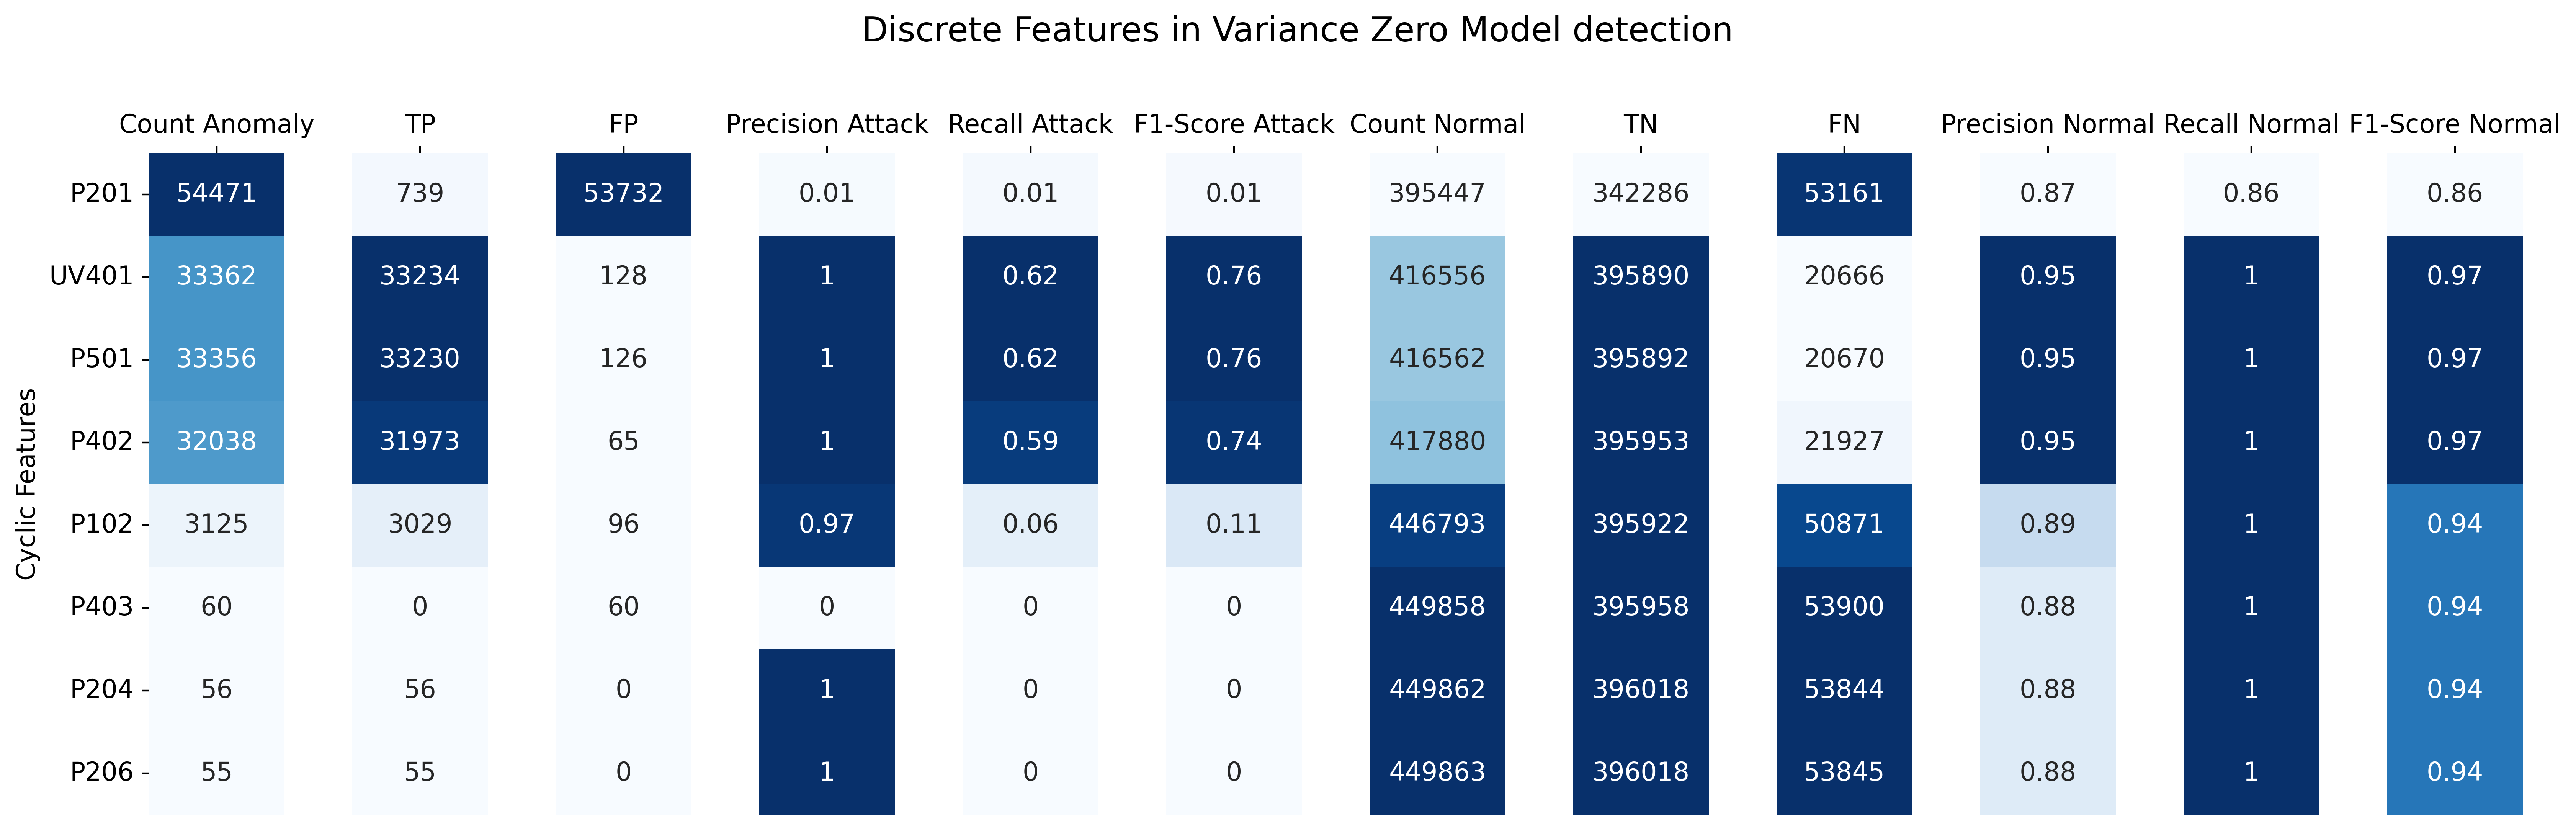

In [332]:
# fig, ax = plt.subplots(figsize=(20, 5), dpi=300)
fig = plt.figure(figsize=(20, 6), dpi=400)

fig.suptitle('Discrete Features in Variance Zero Model detection', fontsize=16)

fig.subplots_adjust(top=0.83)

plt.rcParams.update({'font.size': 12})

gs = fig.add_gridspec(1, 12)

cols_keep = ['count_anomaly', 'attack_well_detected', 'attack_wrong_detected', 'precision_attack', 'recall_attack', 'f1-score_attack', 
             'count_normal', 'normal_well_detected', 'normal_wrong_detected', 'precision_normal', 'recall_normal', 'f1-score_normal', ]
cols_name = ['Count Anomaly', 'TP', 'FP', 'Precision Attack', 'Recall Attack', 'F1-Score Attack',
                'Count Normal', 'TN', 'FN', 'Precision Normal', 'Recall Normal', 'F1-Score Normal']

# add a subplot to the figure with 1 row and 1 column
ax1 = fig.add_subplot(gs[0, 0:1])
sns.heatmap(pd.DataFrame(data_var_zero[cols_keep[0]]), annot=True, fmt="g", ax=ax1, cmap='Blues', cbar=False)
ax1.xaxis.tick_top()
ax1.set_xticklabels([cols_name[0]])
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_ylabel('Cyclic Features')

for i in range(1, 12):
    ax2 = fig.add_subplot(gs[0, i:i+1])
    sns.heatmap(pd.DataFrame(np.round(data_var_zero[cols_keep[i]], 2)), annot=True, fmt="g", ax=ax2, cmap='Blues', cbar=False)
    ax2.xaxis.tick_top()
    ax2.set_xticklabels([cols_name[i]])
    ax2.set_ylabel('')
    ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.5)

fig.savefig('discrete_features_var_zero_metrics.pdf', bbox_inches='tight')

## Longest Slope Direction 

In [263]:
model_longest_slope = pd.DataFrame(columns=['col', 'min_up_down', 'max_up_down', 'min_null', 'max_null'])

for col in cols_cyclic:
    
    n = 100
    df_moving_median = get_moving_median(df, col, n)
    train_moving_median = get_moving_median(train, col, n)

    up_down_train = get_up_down_one(train_moving_median, n)
    df_null_train = get_null(train_moving_median, n)
    
    col_df = pd.DataFrame({
        'col': [col],
        'min_up_down': [up_down_train['up_down'].min()],
        'max_up_down': [up_down_train['up_down'].max()],
        'min_null': [df_null_train['null'].min()],
        'max_null': [df_null_train['null'].max()]
    })
    model_longest_slope = pd.concat(objs=[model_longest_slope, col_df], axis=0, ignore_index=True)

model_longest_slope

col min_up_down max_up_down min_null max_null
0   FIT101          -1          86        0       41
1   LIT101          -8          52        0        9
2   FIT201          -1          85        0       32
3  DPIT301          -2          24        0       17
4   FIT301          -1         104        0       19
5   LIT301          -7          38        0        5
6   LIT401          -8          18        0        1
7   FIT601           1        4824        1     4824

In [265]:
def check_anomaly_longest_slope(df, col):
    df[f'anomaly_up_down_{col}'] = 0
    df[f'anomaly_null_{col}'] = 0
    
    df_moving_median = get_moving_median(df, col, 100)
    up_down = get_up_down_one(df_moving_median, 100)
    df_null = get_null(df_moving_median, 100)


    min_up_down = model_longest_slope[model_longest_slope['col'] == col]['min_up_down'].values[0]
    max_up_down = model_longest_slope[model_longest_slope['col'] == col]['max_up_down'].values[0]
    
    min_null = model_longest_slope[model_longest_slope['col'] == col]['min_null'].values[0]
    max_null = model_longest_slope[model_longest_slope['col'] == col]['max_null'].values[0]
    
    df = pd.concat(objs=[up_down, df_null, df], axis=1)
    
    df.loc[(df['up_down'] < min_up_down) | (df['up_down'] > max_up_down), f'anomaly_up_down_{col}'] = 1
    df.loc[(df['null'] < min_null) | (df['null'] > max_null), f'anomaly_null_{col}'] = 1
    
    df = df.drop(columns=['up_down', 'null'])
    return df


In [266]:
cols_cyclic_anomaly = cols_cyclic.copy()
cols_cyclic_anomaly.remove('FIT601')

In [333]:
for col in cols_cyclic_anomaly:
    df_cyclic = check_anomaly_longest_slope(df_cyclic, col)

df_cyclic['longest_slope_anomaly'] = False
for col in cols_cyclic_anomaly:
    df_cyclic['longest_slope_anomaly'] |= df_cyclic[f'anomaly_up_down_{col}'].astype(bool)
    df_cyclic['longest_slope_anomaly'] |= df_cyclic[f'anomaly_null_{col}'].astype(bool)

train_cyclic, test_cyclic = get_train_test_dataset(df_cyclic)

### Accuracy

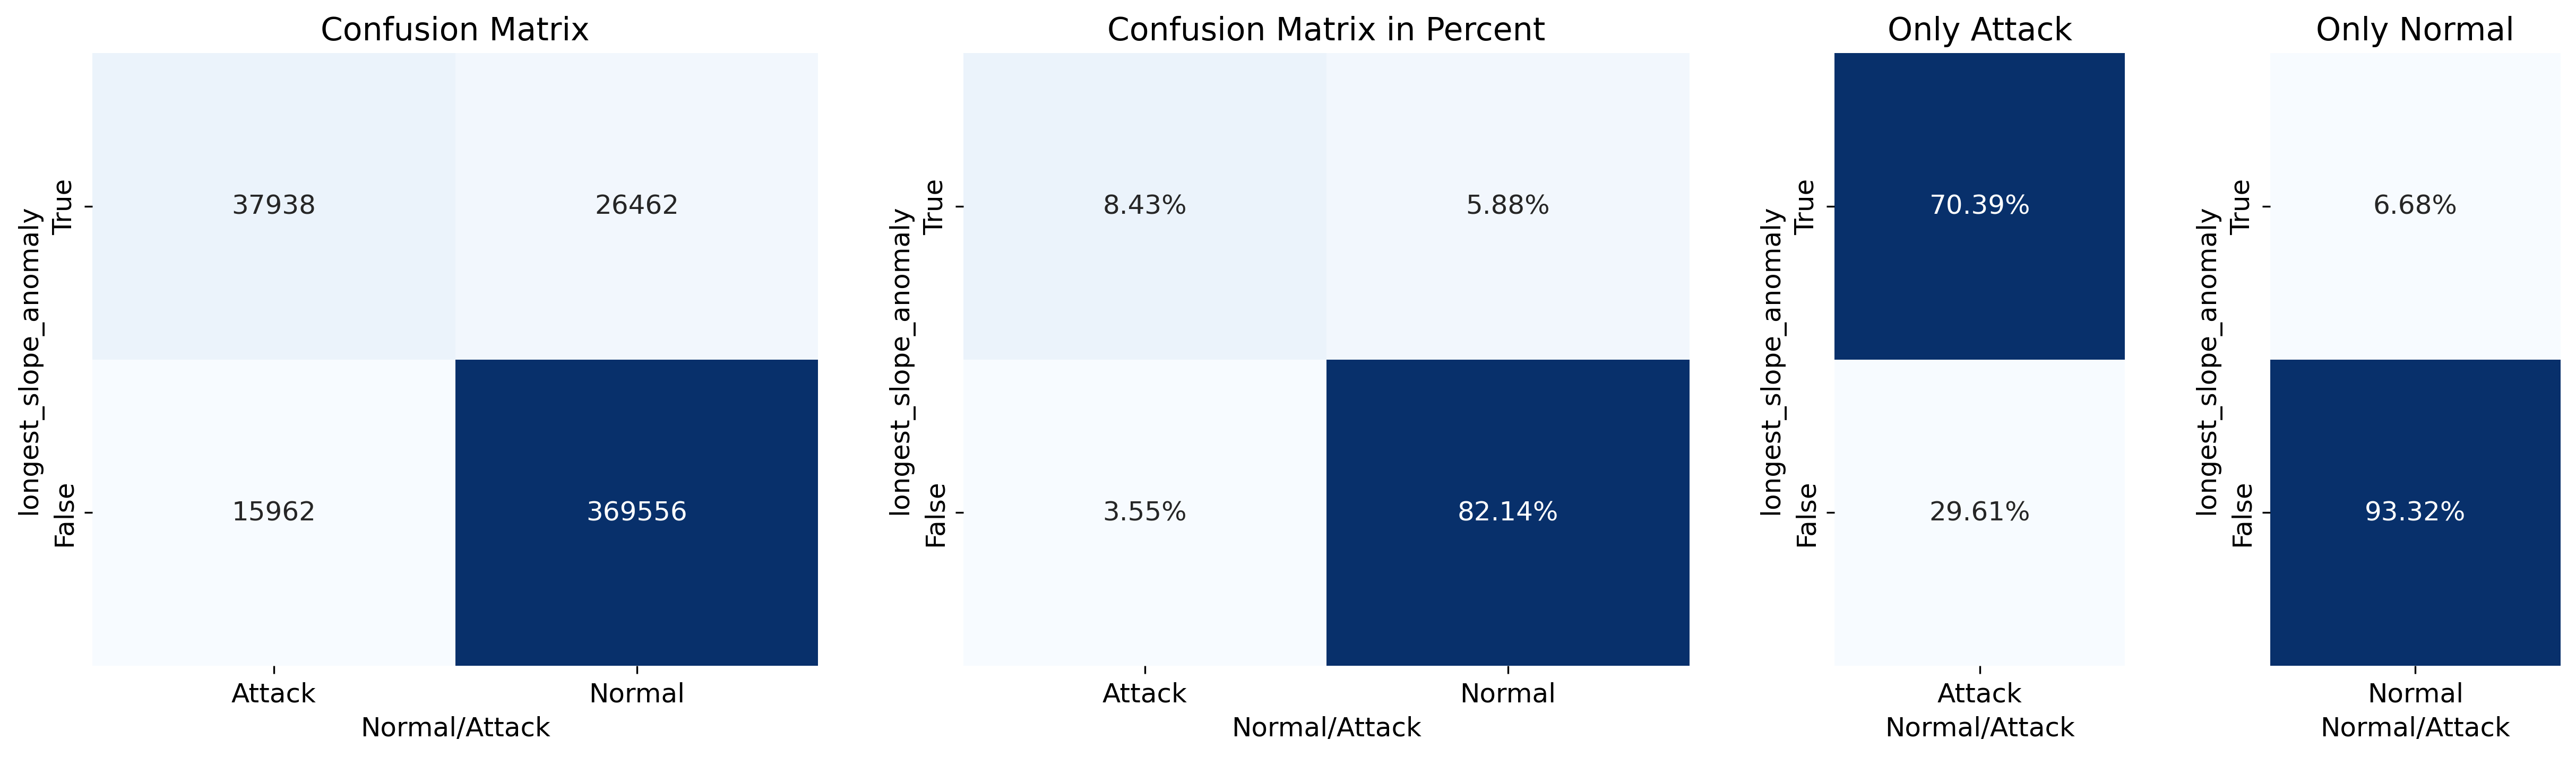

In [268]:
# create a heatmap of the min_max_anomaly and Normal/Attack
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)
# fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=300) 

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['longest_slope_anomaly', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['longest_slope_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['longest_slope_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['longest_slope_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)


In [334]:
test_cyclic['Normal/Attack_int'] = test_cyclic['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

In [335]:
test_cyclic_LS = test_cyclic[[f'anomaly_null_{col}', f'anomaly_up_down_{col}']]

test_cyclic[f'anomaly_null_{col}'] = test_cyclic[f'anomaly_null_{col}'].astype(bool)
test_cyclic[f'anomaly_up_down_{col}'] = test_cyclic[f'anomaly_up_down_{col}'].astype(bool)
test_cyclic_LS[f'anomaly_LS_{col}'] = test_cyclic[f'anomaly_null_{col}'] | test_cyclic[f'anomaly_up_down_{col}']

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_23337/284531886.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cyclic_LS[f'anomaly_LS_{col}'] = test_cyclic[f'anomaly_null_{col}'] | test_cyclic[f'anomaly_up_down_{col}']


In [ ]:

data_LS_cyclic = pd.DataFrame()
for col in cols_cyclic_anomaly:
    labels = ['Normal', 'Attack']
    test_cyclic[f'anomaly_null_{col}'] = test_cyclic[f'anomaly_null_{col}'].astype(bool)
    test_cyclic[f'anomaly_up_down_{col}'] = test_cyclic[f'anomaly_up_down_{col}'].astype(bool)
    test_cyclic_LS = test_cyclic[[f'anomaly_null_{col}', f'anomaly_up_down_{col}', 'Normal/Attack_int']]
    
    test_cyclic_LS[f'anomaly_LS_{col}'] = test_cyclic[f'anomaly_null_{col}'] | test_cyclic[f'anomaly_up_down_{col}']
    
    class_report = classification_report(test_cyclic_LS['Normal/Attack_int'], test_cyclic_LS[f'anomaly_LS_{col}'], target_names=labels, output_dict=True)
    cm = confusion_matrix(df_cyclic_test['Normal/Attack_int'], test_cyclic_LS[f'anomaly_LS_{col}'])
    data_LS_cyclic = pd.concat([data_LS_cyclic, pd.DataFrame({
        'col': col, 
        'precision_attack': class_report['Attack']['precision'], 
        'precision_normal': class_report['Normal']['precision'], 
        'recall_attack': class_report['Attack']['recall'], 
        'recall_normal': class_report['Normal']['recall'], 
        'f1-score_attack': class_report['Attack']['f1-score'], 
        'f1-score_normal': class_report['Normal']['f1-score'], 
        'count_anomaly': test_cyclic_LS[test_cyclic_LS[f'anomaly_LS_{col}'] == 1].shape[0],
        'count_normal': test_cyclic_LS[test_cyclic_LS[f'anomaly_LS_{col}'] == 0].shape[0],
        'attack_well_detected': cm[1][1],
        'normal_well_detected': cm[0][0],
    }, index=[0])], axis=0)

data_LS_cyclic['attack_wrong_detected'] = data_LS_cyclic['count_anomaly'] - data_LS_cyclic['attack_well_detected']
data_LS_cyclic['normal_wrong_detected'] = data_LS_cyclic['count_normal'] - data_LS_cyclic['normal_well_detected']

data_LS_cyclic.index = data_LS_cyclic['col']
data_LS_cyclic = data_LS_cyclic.sort_values(by='count_anomaly', ascending=False)

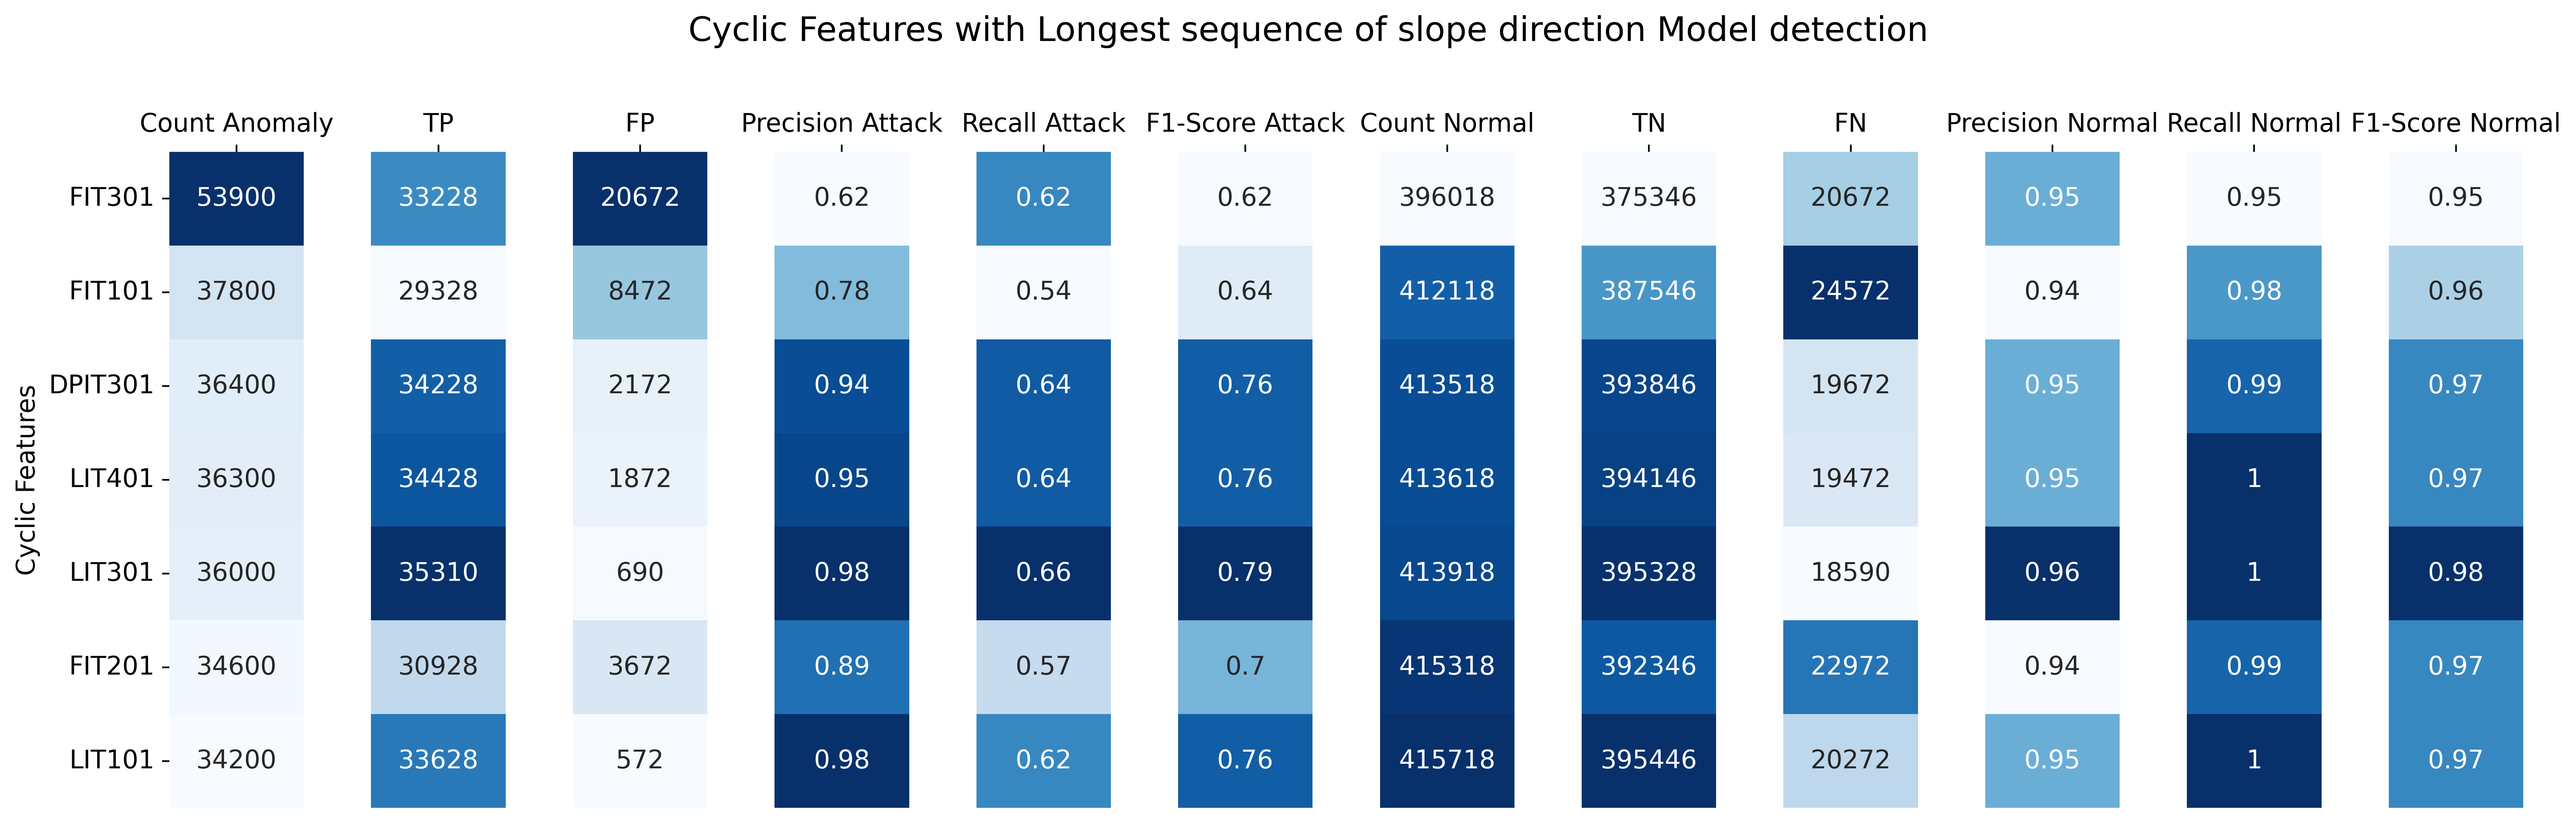

In [378]:
fig = plt.figure(figsize=(20, 6), dpi=400)

fig.suptitle('Cyclic Features with Longest sequence of slope direction Model detection', fontsize=16)
fig.subplots_adjust(top=0.83)

plt.rcParams.update({'font.size': 12})

gs = fig.add_gridspec(1, 12)

cols_keep = ['count_anomaly', 'attack_well_detected', 'attack_wrong_detected', 'precision_attack', 'recall_attack', 'f1-score_attack', 
             'count_normal', 'normal_well_detected', 'normal_wrong_detected', 'precision_normal', 'recall_normal', 'f1-score_normal', ]
cols_name = ['Count Anomaly', 'TP', 'FP', 'Precision Attack', 'Recall Attack', 'F1-Score Attack',
             'Count Normal', 'TN', 'FN', 'Precision Normal', 'Recall Normal', 'F1-Score Normal']

# add a subplot to the figure with 1 row and 1 column
ax1 = fig.add_subplot(gs[0, 0:1])
sns.heatmap(pd.DataFrame(data_LS_cyclic[cols_keep[0]]), annot=True, fmt="g", ax=ax1, cmap='Blues', cbar=False)
ax1.xaxis.tick_top()
ax1.set_xticklabels([cols_name[0]])
ax1.set_ylabel('Cyclic Features')

for i in range(1, 12):
    ax2 = fig.add_subplot(gs[0, i:i+1])
    sns.heatmap(pd.DataFrame(np.round(data_LS_cyclic[cols_keep[i]], 2)), annot=True, fmt="g", ax=ax2, cmap='Blues', cbar=False)
    ax2.xaxis.tick_top()
    ax2.set_xticklabels([cols_name[i]])
    ax2.set_ylabel('')
    ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.5)

fig.savefig('cyclic_feature_LS_cyclic.pdf', bbox_inches='tight')

## Longest Discrete Value

In [284]:
# Interquartile Range 0.001 - 0.999
def IQR_keep(df, col):

    Q1 = np.quantile(df[col], 0.001)
    Q3 = np.quantile(df[col], 0.999)
    IQR = Q3 - Q1

    # Above Upper bound
    upper = df[col] > (Q3+1.5*IQR)

    # Below Lower bound
    lower = df[col] < (Q1-1.5*IQR)

    keep = ~upper & ~lower
    return Q1, Q3, IQR, keep


def get_islands_index(arr, mask, col, value):
    mask_ = np.concatenate(( [False], mask, [False] ))
    idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
    
    arr[f'anomaly_{col}_{value}'] = 0
    arr[f'slope_{col}_{value}'] = 0
    
    for i in range(0, len(idx), 2):
        len_ = len(arr[idx[i]:idx[i+1] + 1])
        arr.loc[idx[i]:idx[i+1], f'slope_{col}_{value}'] = [i for i in range(len_)]
        
    train_arr, _ = get_train_test_dataset(arr[[f'slope_{col}_{value}', 'Timestamp']])
    min_ = train_arr[f'slope_{col}_{value}'].min()
    max_ = train_arr[f'slope_{col}_{value}'].max()

    arr.loc[(arr[f'slope_{col}_{value}'] < min_) | (arr[f'slope_{col}_{value}'] > max_), f'anomaly_{col}_{value}'] = 1
    return arr

In [285]:
cols_not_var_zero_discrete = []
for col in cols_discrete:
    if np.var(train[col]) != 0:
        
        Q1, Q3, IQR, keep = IQR_keep(train, col)
        data = train[keep][col]
        if np.var(data) != 0:
            cols_not_var_zero_discrete.append(col)

df_discrete_LS = df[cols_not_var_zero_discrete+['Normal/Attack', 'Timestamp']].copy()
df_discrete_LS['anomaly_discrete_LS'] = False

for col in cols_not_var_zero_discrete:
    unique_value = train[col].unique()

    for value in unique_value:
        mask = df[col] == value
        
        df_discrete_LS = get_islands_index(df_discrete_LS, mask, col, value)
        df_discrete_LS['anomaly_discrete_LS'] |= df_discrete_LS[f'anomaly_{col}_{value}'].astype(bool)

df_discrete_LS_train, df_discrete_LS_test = get_train_test_dataset(df_discrete_LS)

In [353]:
df_cyclic['anomaly_discrete_LS'] = df_discrete_LS['anomaly_discrete_LS']

### Accuracy

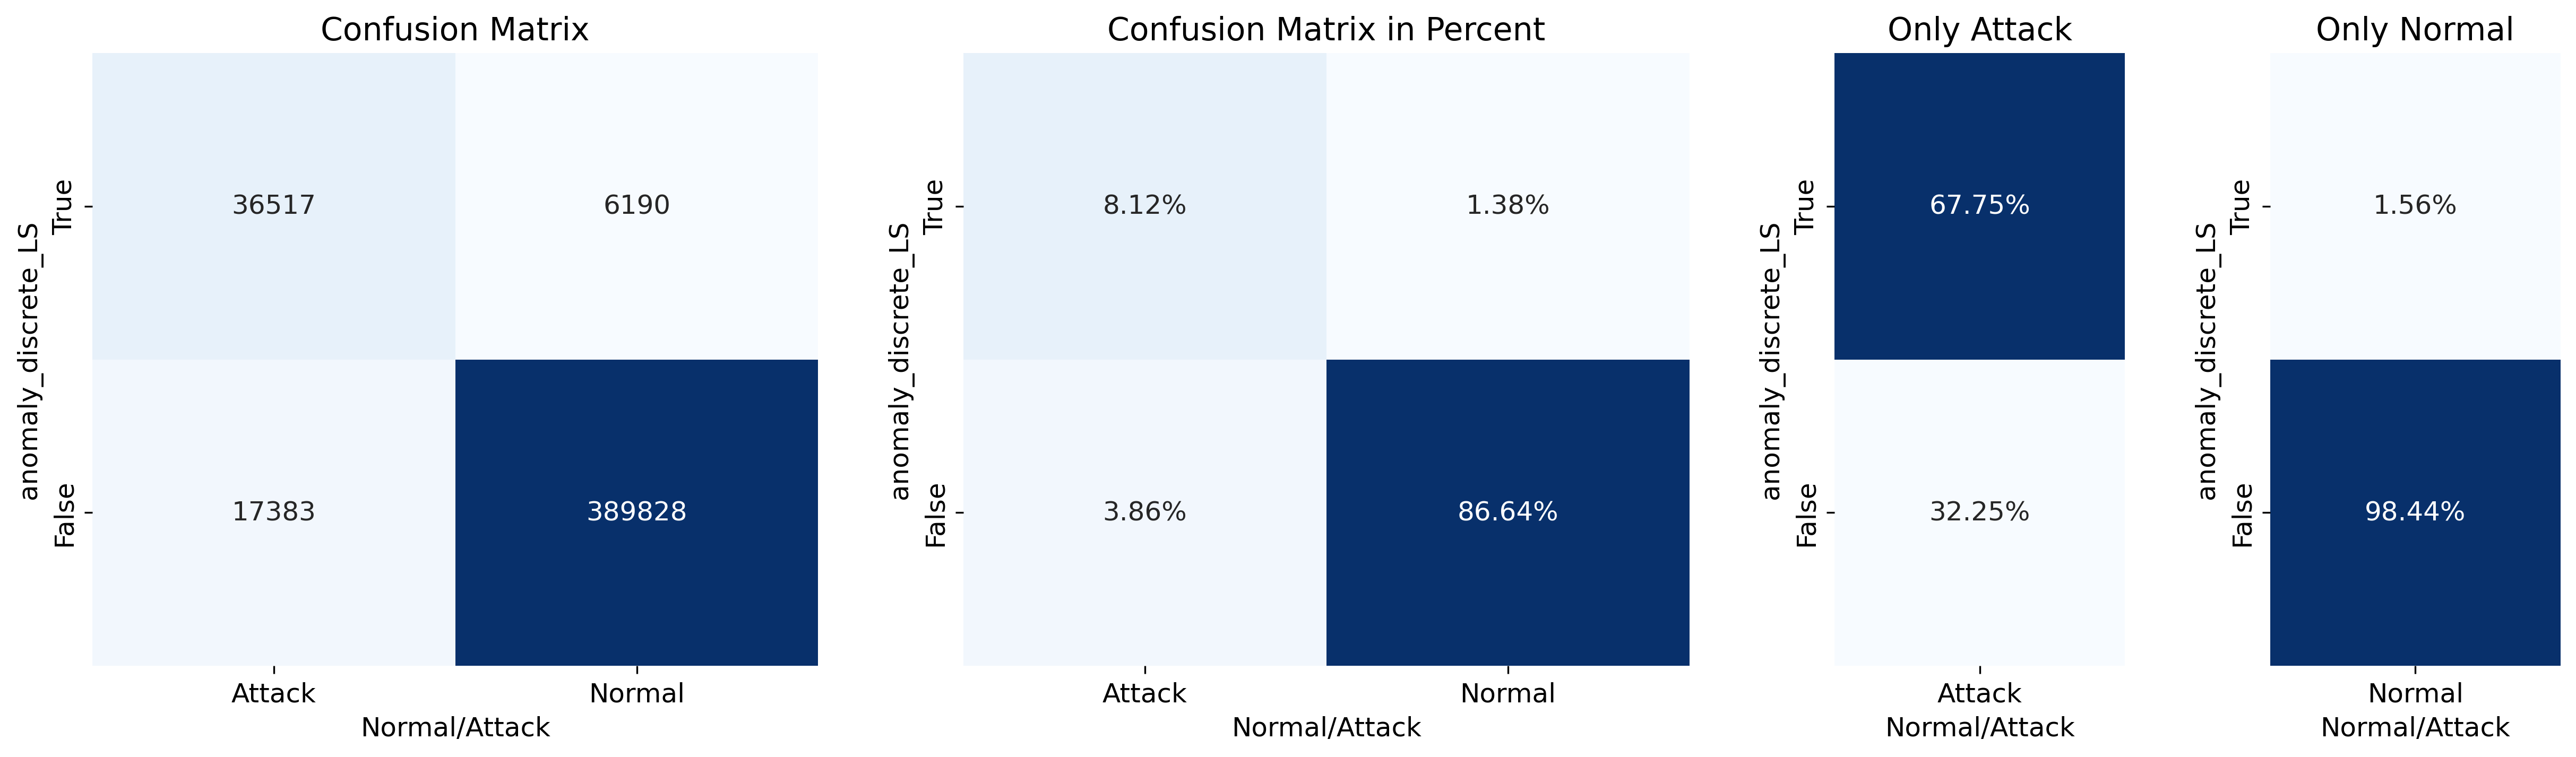

In [287]:
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['anomaly_discrete_LS', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['anomaly_discrete_LS', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['anomaly_discrete_LS', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['anomaly_discrete_LS', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [288]:
for col in cols_not_var_zero_discrete:
    matching = [s for s in list(df_discrete_LS_test.columns) if col in f'anomaly_{s}' and 'anomaly' in s]
    df_discrete_LS_test[f'anomaly_{col}'] = False
    for c in matching:
        df_discrete_LS_test[f'anomaly_{col}'] |= df_discrete_LS_test[c].astype(bool)

In [339]:
df_discrete_LS_test['Normal/Attack_int'] = df_discrete_LS_test['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

data_LS_discrete = pd.DataFrame()
for col in cols_not_var_zero_discrete:
    # class_report = classification_report(df_cyclic_test['Normal/Attack_int'], df_cyclic_test[f'anomaly_{col}'], output_dict=True)
    labels = ['Normal', 'Attack']
    class_report = classification_report(df_discrete_LS_test['Normal/Attack_int'], df_discrete_LS_test[f'anomaly_{col}'], target_names=labels, output_dict=True)
    cm = confusion_matrix(df_cyclic_test['Normal/Attack_int'], df_discrete_LS_test[f'anomaly_{col}'])
    data_LS_discrete = pd.concat([data_LS_discrete, pd.DataFrame({
        'col': col, 
        'precision_attack': class_report['Attack']['precision'], 
        'precision_normal': class_report['Normal']['precision'], 
        'recall_attack': class_report['Attack']['recall'], 
        'recall_normal': class_report['Normal']['recall'], 
        'f1-score_attack': class_report['Attack']['f1-score'], 
        'f1-score_normal': class_report['Normal']['f1-score'], 
        'count_anomaly': df_discrete_LS_test[df_discrete_LS_test[f'anomaly_{col}'] == 1].shape[0],
        'count_normal': df_discrete_LS_test[df_discrete_LS_test[f'anomaly_{col}'] == 0].shape[0],
        'attack_well_detected': cm[1][1],
        'normal_well_detected': cm[0][0],
    }, index=[0])], axis=0)

data_LS_discrete['attack_wrong_detected'] = data_LS_discrete['count_anomaly'] - data_LS_discrete['attack_well_detected']
data_LS_discrete['normal_wrong_detected'] = data_LS_discrete['count_normal'] - data_LS_discrete['normal_well_detected']

data_LS_discrete.index = data_LS_discrete['col']
data_LS_discrete = data_LS_discrete.sort_values(by='count_anomaly', ascending=False)

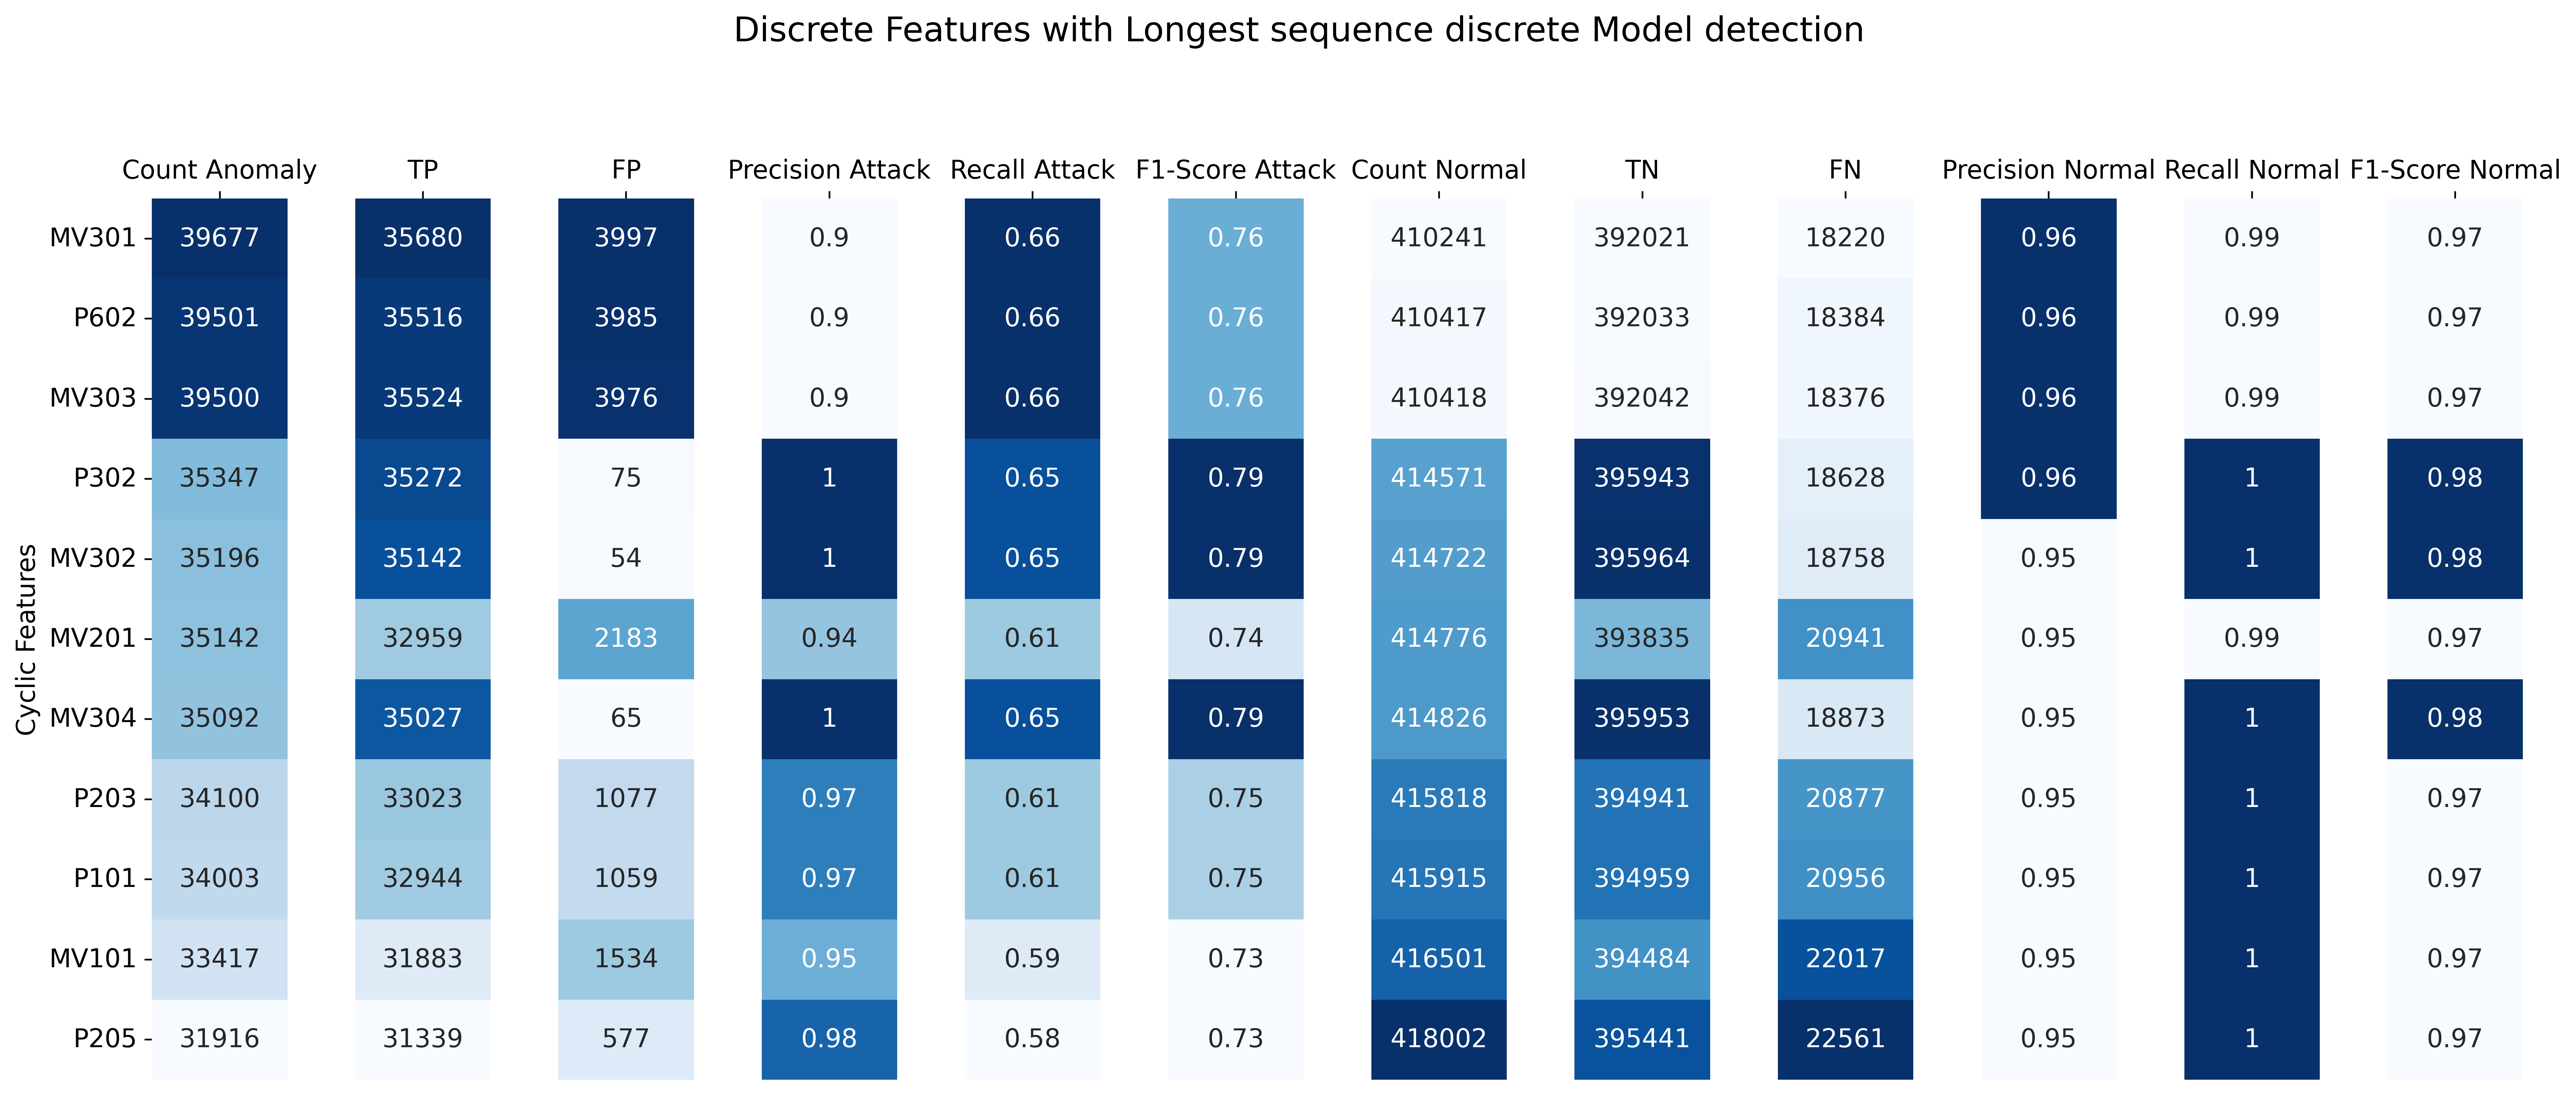

In [377]:
fig = plt.figure(figsize=(20, 8), dpi=400)
# change the title of the figure
fig.suptitle('Discrete Features with Longest sequence discrete Model detection', fontsize=16)

fig.subplots_adjust(top=0.83)

plt.rcParams.update({'font.size': 12})

gs = fig.add_gridspec(1, 12)

cols_keep = ['count_anomaly', 'attack_well_detected', 'attack_wrong_detected', 'precision_attack', 'recall_attack', 'f1-score_attack', 
             'count_normal', 'normal_well_detected', 'normal_wrong_detected', 'precision_normal', 'recall_normal', 'f1-score_normal', ]
cols_name = ['Count Anomaly', 'TP', 'FP', 'Precision Attack', 'Recall Attack', 'F1-Score Attack',
                'Count Normal', 'TN', 'FN', 'Precision Normal', 'Recall Normal', 'F1-Score Normal']

# add a subplot to the figure with 1 row and 1 column
ax1 = fig.add_subplot(gs[0, 0:1])
sns.heatmap(pd.DataFrame(data_LS_discrete[cols_keep[0]]), annot=True, fmt="g", ax=ax1, cmap='Blues', cbar=False)
ax1.xaxis.tick_top()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_xticklabels([cols_name[0]])
ax1.set_ylabel('Cyclic Features')

for i in range(1, 12):
    ax2 = fig.add_subplot(gs[0, i:i+1])
    sns.heatmap(pd.DataFrame(np.round(data_LS_discrete[cols_keep[i]], 2)), annot=True, fmt="g", ax=ax2, cmap='Blues', cbar=False)
    ax2.xaxis.tick_top()
    ax2.set_xticklabels([cols_name[i]])
    ax2.set_ylabel('')
    ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.5)

fig.savefig('discrete_feature_LS_discrete.pdf', bbox_inches='tight')

## Markov Chain Model

### Creation of state

In [34]:
def get_discrete_status(row, quantiles):
    # point = [i for i in range(quantiles)]
    for i, quantile in enumerate(quantiles):
        if row <= quantile:
            return i
        
    return len(quantiles)

In [35]:
discrete_cols = []

df_state = df[['Timestamp']+cols_discrete].copy()

for col in cols_discrete:
    if col not in cols_var_zero_discrete:
        discrete_cols.append(f'{col}_discrete')
    
for col in cols_acyclic:
    discrete_cols.append(f'{col}_discrete')
    
for col in cols_cyclic:
    discrete_cols.append(f'{col}_discrete')

In [264]:
def get_slope_feature(data, n):

    slope_feature = [0] * 1 + [ x for x in np.diff(np.array(data))]

    slope_adjusted = []
    
    for i in range(0, len(data) - n, n):
        mean = np.mean(slope_feature[i:i+n])
        for j in range(n):
            slope_adjusted.append(mean)
    for j in range(19):
            slope_adjusted.append(mean)
    return pd.DataFrame(slope_adjusted)


def get_moving_median_state(df, col, n):
    median_moving = []
    for i in range(0, len(df) - n, n):
        med = np.median(df.iloc[i:i+n][col])
        for j in range(n):
            median_moving.append(med)
    for j in range(19):
            median_moving.append(med)
    
    return pd.DataFrame(median_moving)

In [40]:
# Add Cols discretes
for col in cols_discrete:
    if col not in cols_var_zero_discrete:
        df_state[f'{col}_discrete'] = df[col]

n = 100
for col in cols_continuous:
    # median_sliding = df[col].rolling(window=n).median()
    # df_state[f'{col}_slope'] = get_slope_feature(median_sliding, n)
    moving_median = get_moving_median_state(df, col, n)
    df_state[f'{col}_slope'] = get_slope_feature(moving_median[0], n)

df_state_train, df_state_test = get_train_test_dataset(df_state)

In [42]:

for col in cols_continuous:
    quantiles =  df_state_train[f'{col}_slope'].quantile([0.001, 0.999])
    df_state[f'{col}_discrete'] = df_state[f'{col}_slope'].apply(lambda x: get_discrete_status(x, quantiles))


In [43]:

def set_state(row):
    state = str('')
    for value in row:
        state += str(value)
    return state

df_state['state'] = df_state[discrete_cols].apply(lambda row: set_state(row), axis=1)

df_state['attack'] = df['attack']
df_state['Normal/Attack'] = df['Normal/Attack']

df_state_train, df_state_test = get_train_test_dataset(df_state)

len(df_state['state'].unique())

1129

In [ ]:
keep = ['Timestamp', 'state', 'attack', 'Normal/Attack']
df_state_anomaly = df_state[keep]

df_state_anomaly_train, df_state_anomaly_test = get_train_test_dataset(df_state_anomaly)

know_state = list(df_state_anomaly_train['state'].unique())

df_state_anomaly_train['known'] = 1
df_state_anomaly_test['known'] = df_state_anomaly_test['state'].apply(lambda x: 1 if x in know_state else 0)

df_state_know = pd.concat(objs=[df_state_anomaly_train, df_state_anomaly_test], axis=0)

df_state_know['state_not_detected'] = df_state_know['known'].apply(lambda x: 1 if x == 0 else 0)

state_anomaly_train, state_anomaly_test = get_train_test_dataset(df_state_anomaly)


In [380]:
df_cyclic['state_not_detected'] = df_state_know['state_not_detected'].astype(bool)

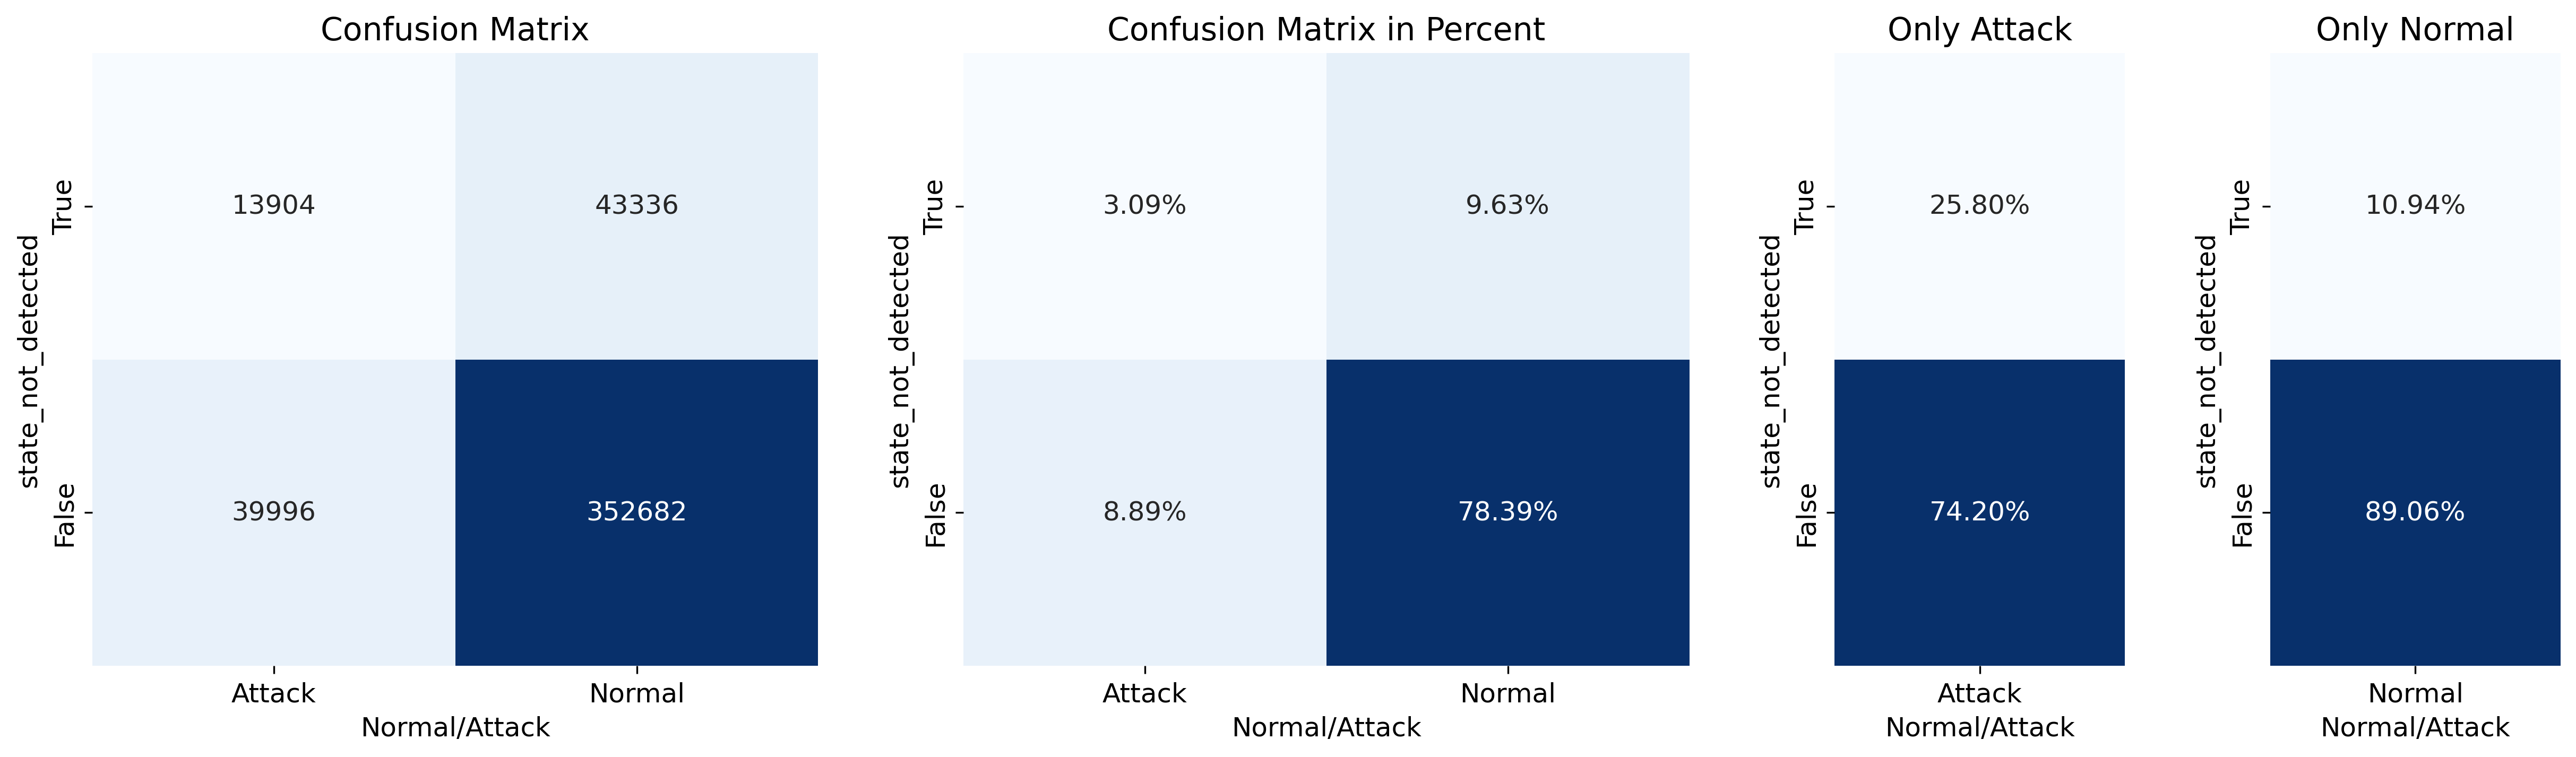

In [381]:
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['state_not_detected', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['state_not_detected', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['state_not_detected', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['state_not_detected', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)

fig.savefig('confusion_matrix_state_anomaly.pdf', bbox_inches='tight')

# Multi-Model Evaluation

In [293]:
df_cyclic['multimodel_anomaly'] = df_cyclic['min_max_anomaly'] | df_cyclic['state_not_detected'] | df_cyclic['longest_slope_anomaly'] | df_cyclic['anomaly_discrete_LS'] | df_cyclic['anomaly_var_zero']

### Example of multimodel anomaly detection

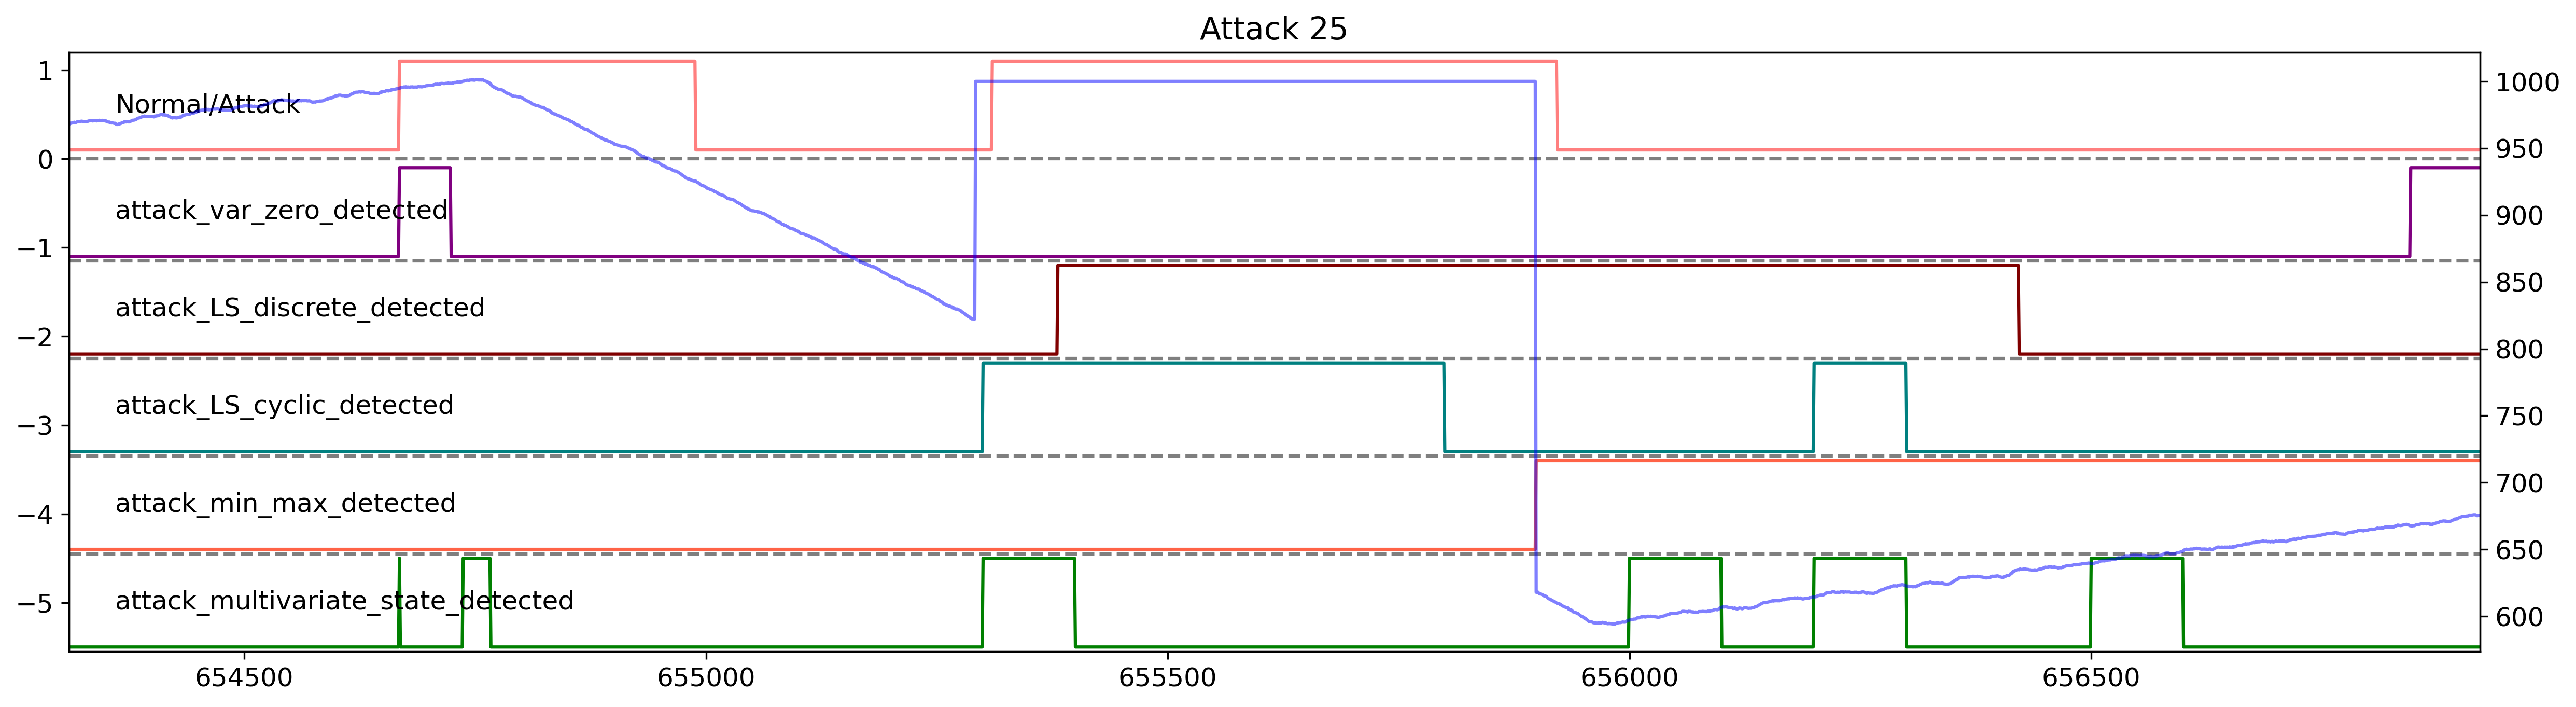

In [375]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=300)
attack = 25
index_min, index_max = get_timestamp_attack(index_attack=attack, offset=1000)
    
ax.text(index_min + 50, -5.5 + 0.5, f'attack_multivariate_state_detected', horizontalalignment='left', verticalalignment='center')
ax.plot(df_state_know.iloc[index_min:index_max]['state_not_detected'] - 5.5, color='green', alpha=1)
ax.axhline(y=-4.45, color='black', alpha=0.5, linestyle='--')

ax.text(index_min + 50, -4.4 + 0.5, f'attack_min_max_detected', horizontalalignment='left', verticalalignment='center')
ax.plot(df_cyclic.iloc[index_min:index_max]['min_max_anomaly'] - 4.4, color='tomato', alpha=1)
ax.axhline(y=-3.35, color='black', alpha=0.5, linestyle='--')

ax.text(index_min + 50, -3.3 + 0.5, f'attack_LS_cyclic_detected', horizontalalignment='left', verticalalignment='center')
ax.plot(df_cyclic.iloc[index_min:index_max]['longest_slope_anomaly'] - 3.3, color='teal', alpha=1)
ax.axhline(y=-2.25, color='black', alpha=0.5, linestyle='--')

ax.text(index_min + 50, -2.2 + 0.5, f'attack_LS_discrete_detected', horizontalalignment='left', verticalalignment='center')
ax.plot(df_cyclic.iloc[index_min:index_max]['anomaly_discrete_LS'] - 2.2, color='maroon', alpha=1)
ax.axhline(y=-1.15, color='black', alpha=0.5, linestyle='--')

ax.text(index_min + 50, -1.1 + 0.5, f'attack_var_zero_detected', horizontalalignment='left', verticalalignment='center')
ax.plot(df_cyclic.iloc[index_min:index_max]['anomaly_var_zero'] - 1.1, color='purple', alpha=1)
ax.axhline(y=0, color='black', alpha=0.5, linestyle='--')

ax.text(index_min + 50, 0.1 + 0.5, f'Normal/Attack', horizontalalignment='left', verticalalignment='center')
ax.plot(df_cyclic['Normal/Attack_int'][index_min:index_max] + 0.1, color='red', alpha=0.5)

ax1 = ax.twinx()
ax1.plot(df['LIT401'][index_min:index_max], color='blue', alpha=0.5)

ax.set_ylim(-5.55, 1.2)
ax.set_xlim(index_min, index_max)

ax.set_title(f'Attack {attack}')

fig.savefig(f'./images/attack_{attack}_multimodel.pdf', bbox_inches='tight')

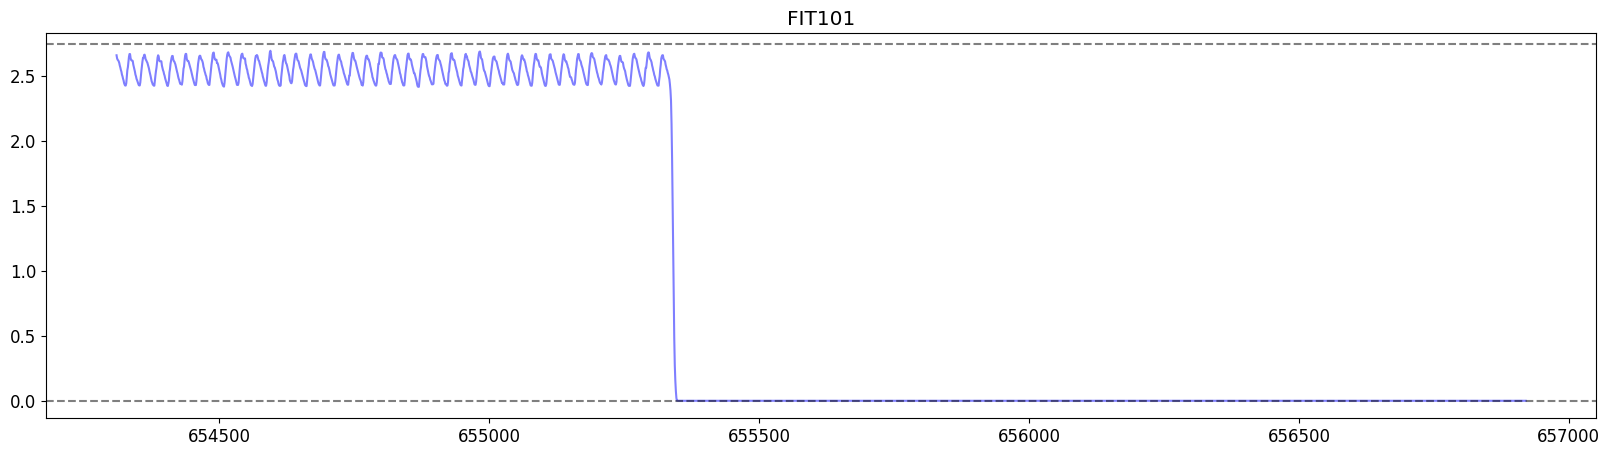

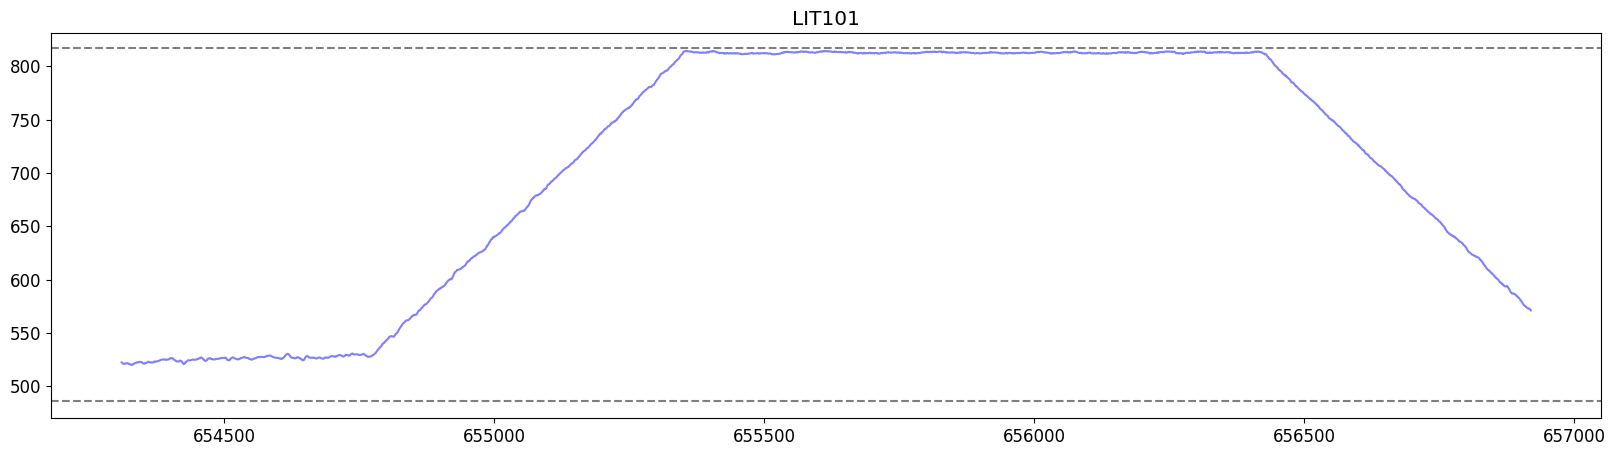

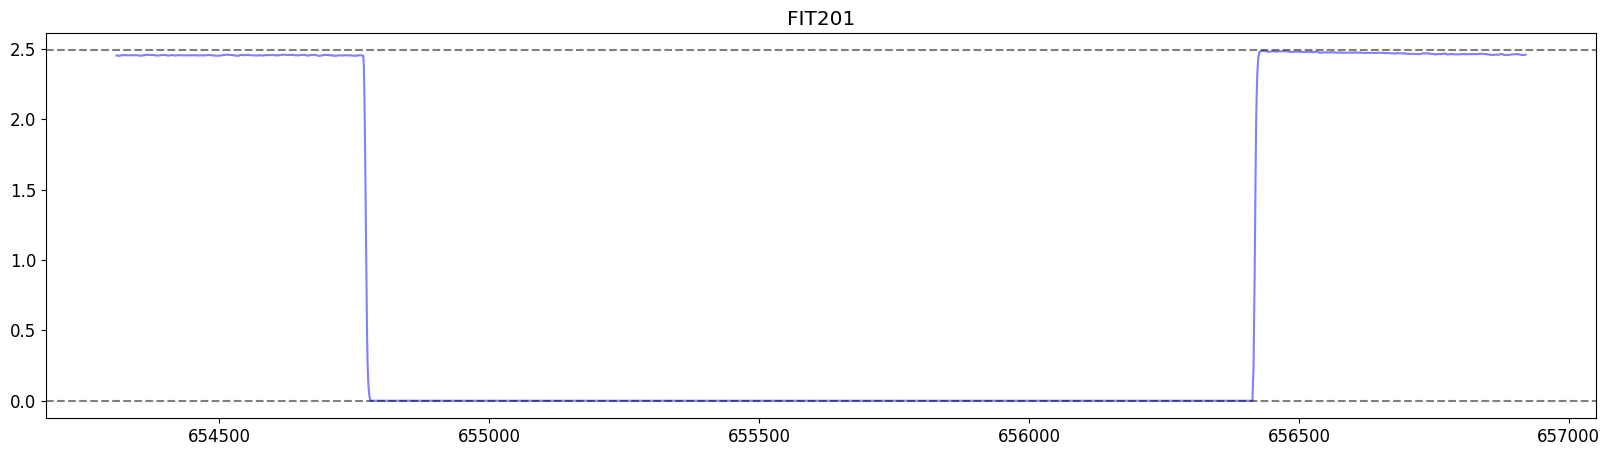

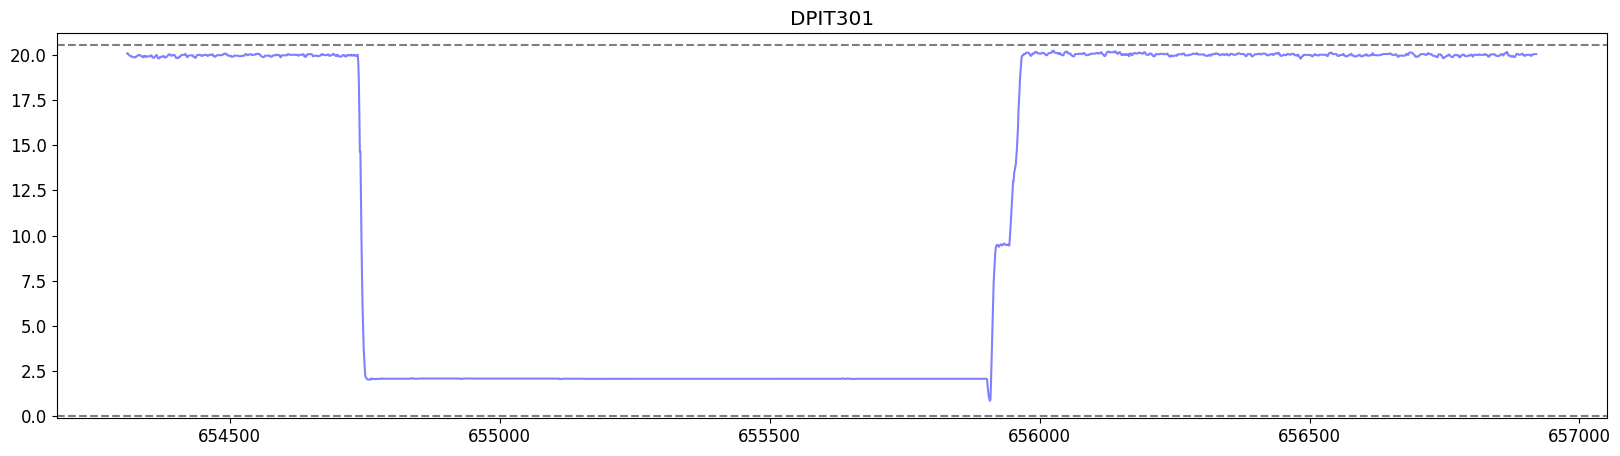

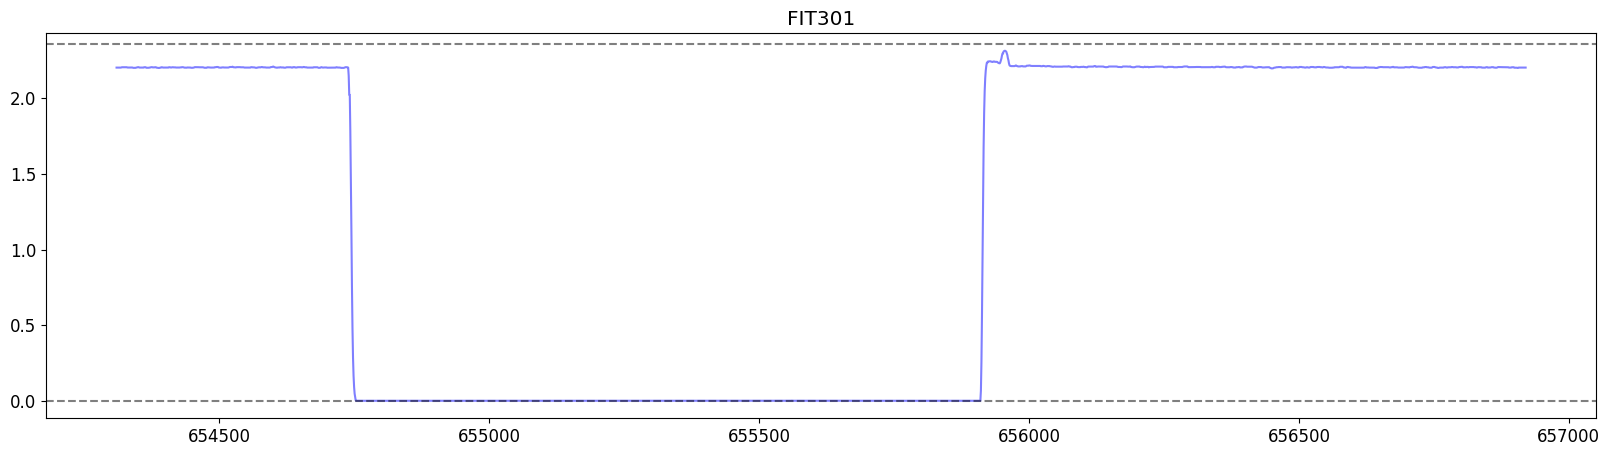

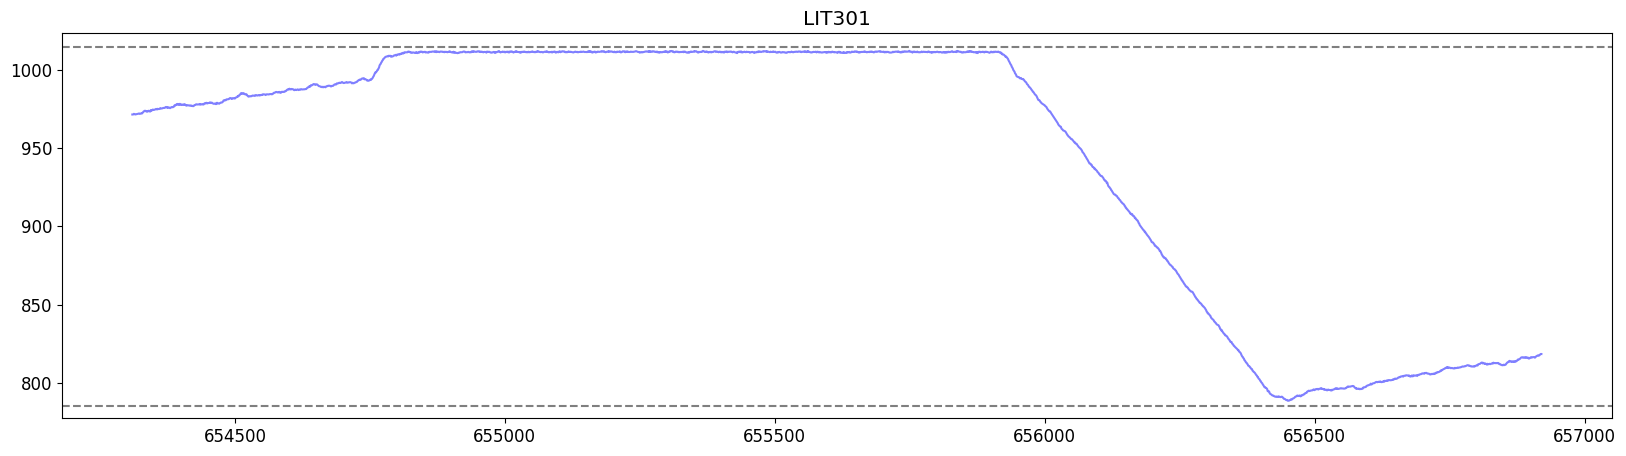

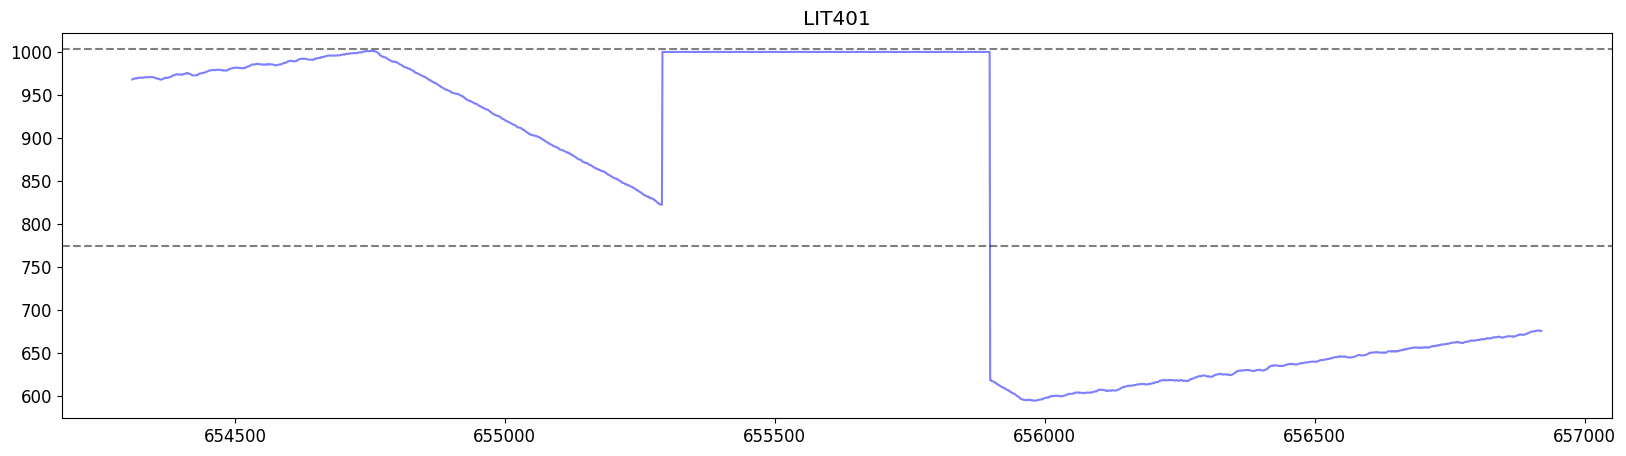

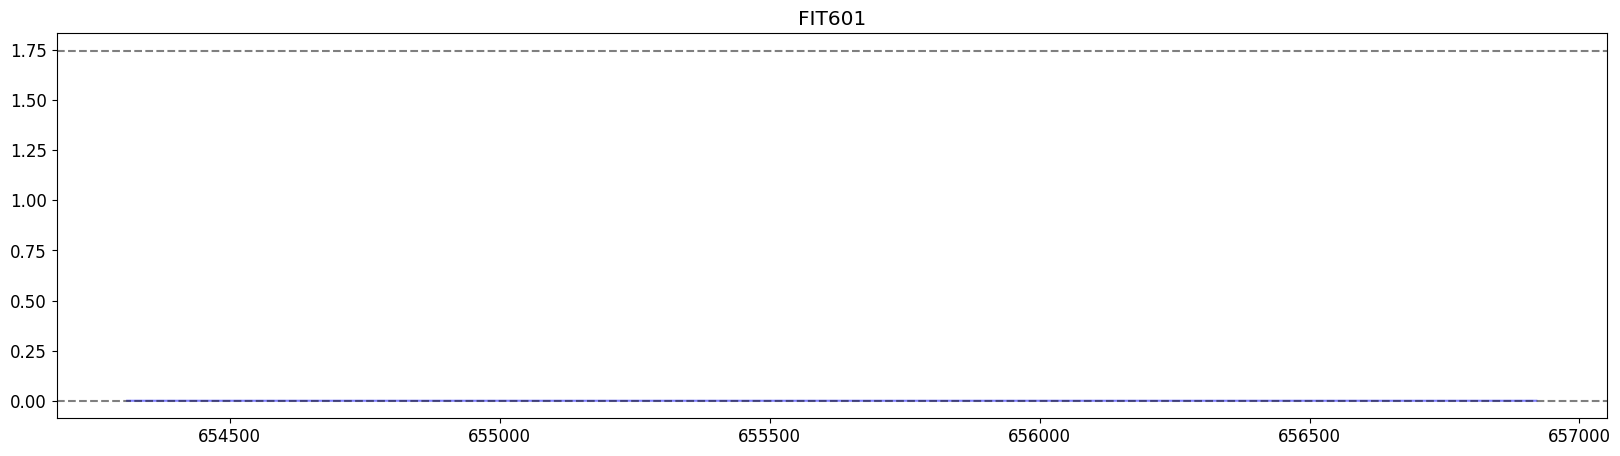

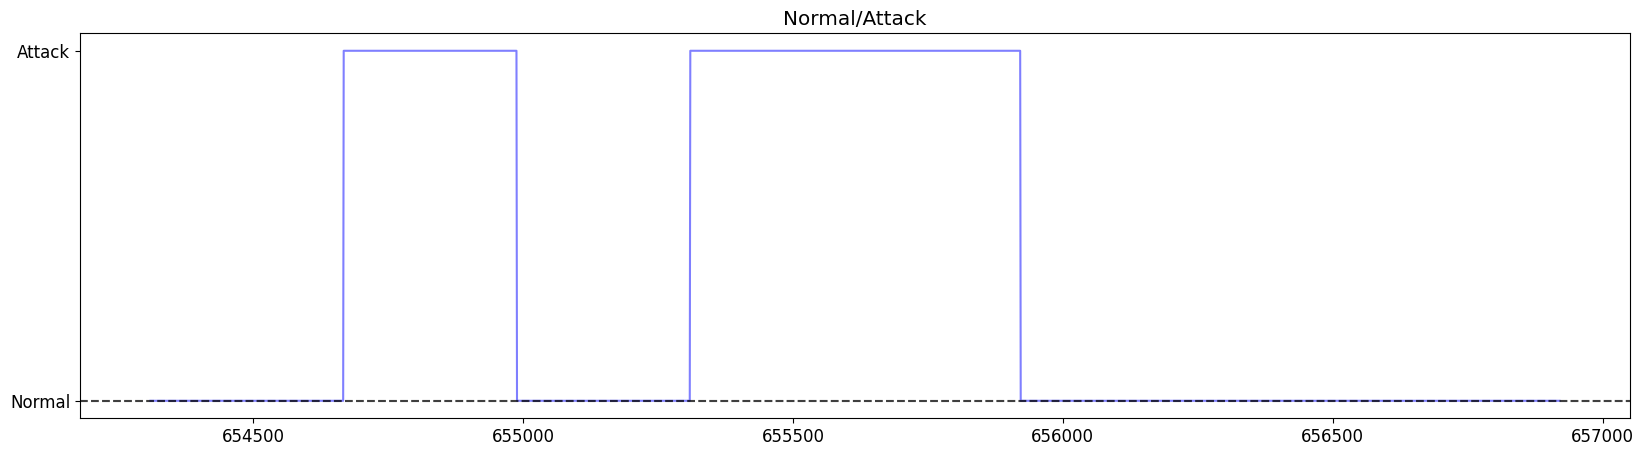

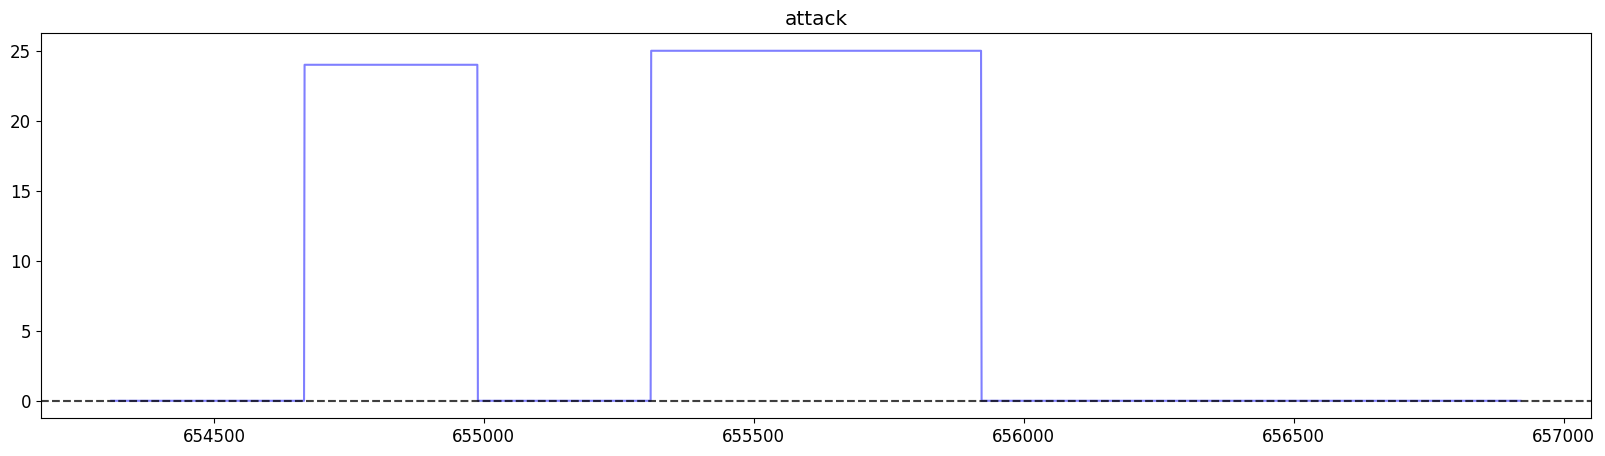

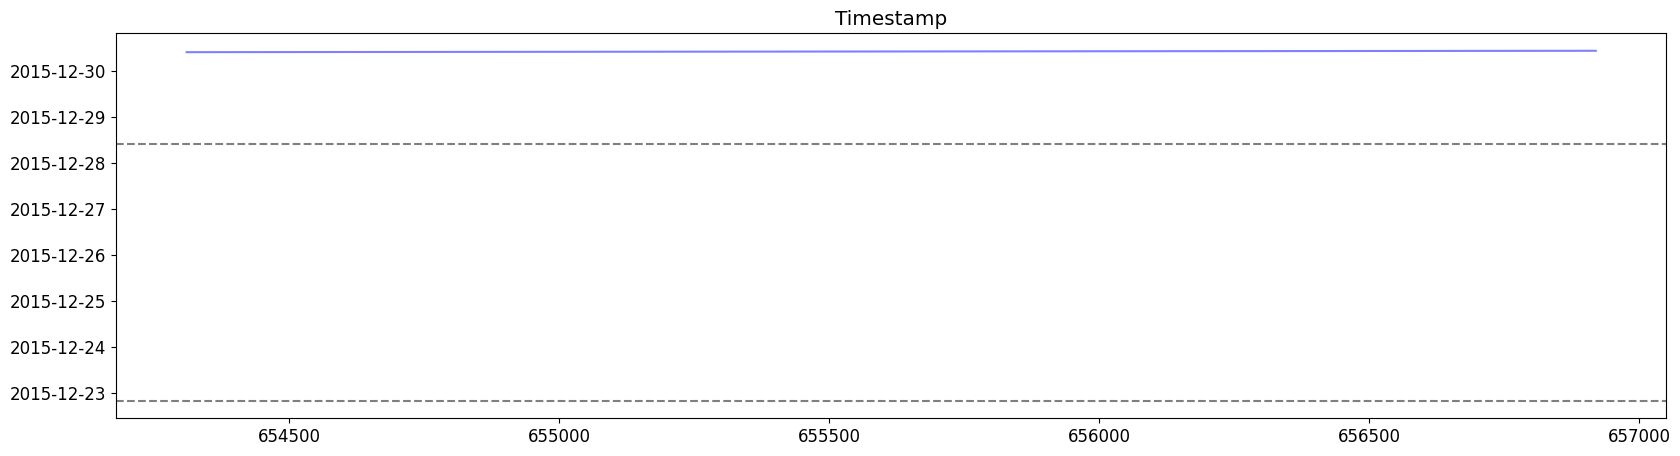

KeyError: 'Normal/Attack_int'

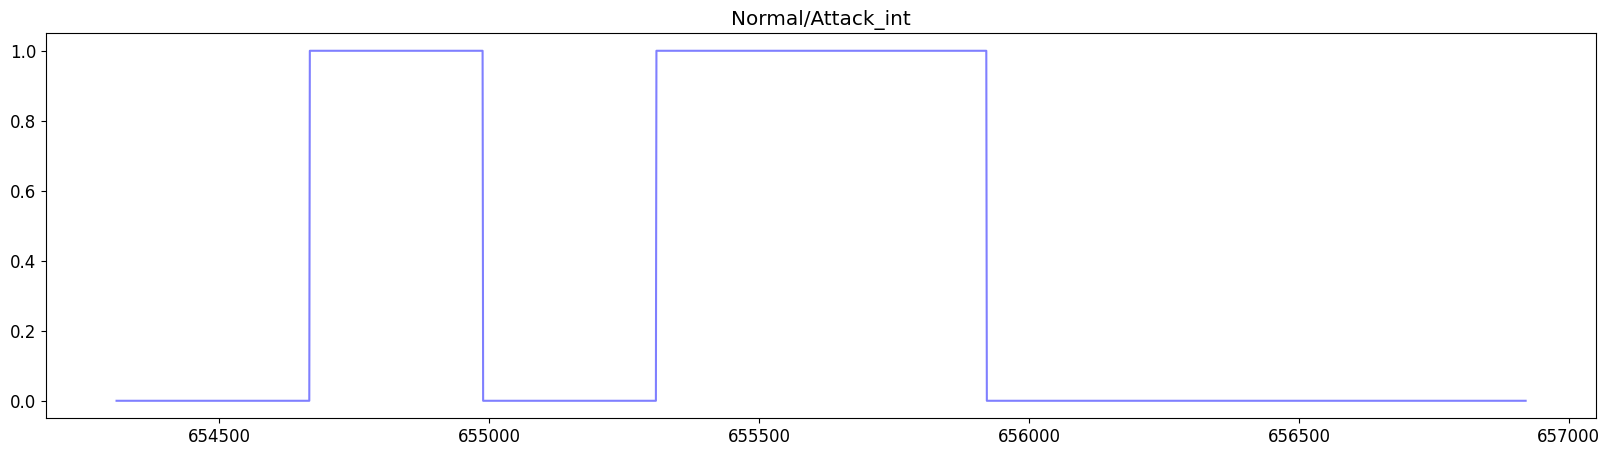

In [359]:
for col in df_cyclic.columns:
    index_min, index_max = get_timestamp_attack(index_attack=25, offset=1000)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(df_cyclic[col][index_min:index_max], color='blue', alpha=0.5)
    ax.set_title(f'{col}')
    ax.axhline(y=train[col].min(), color='black', alpha=0.5, linestyle='--')
    ax.axhline(y=train[col].max(), color='black', alpha=0.5, linestyle='--')
    plt.show()

### Accuracy

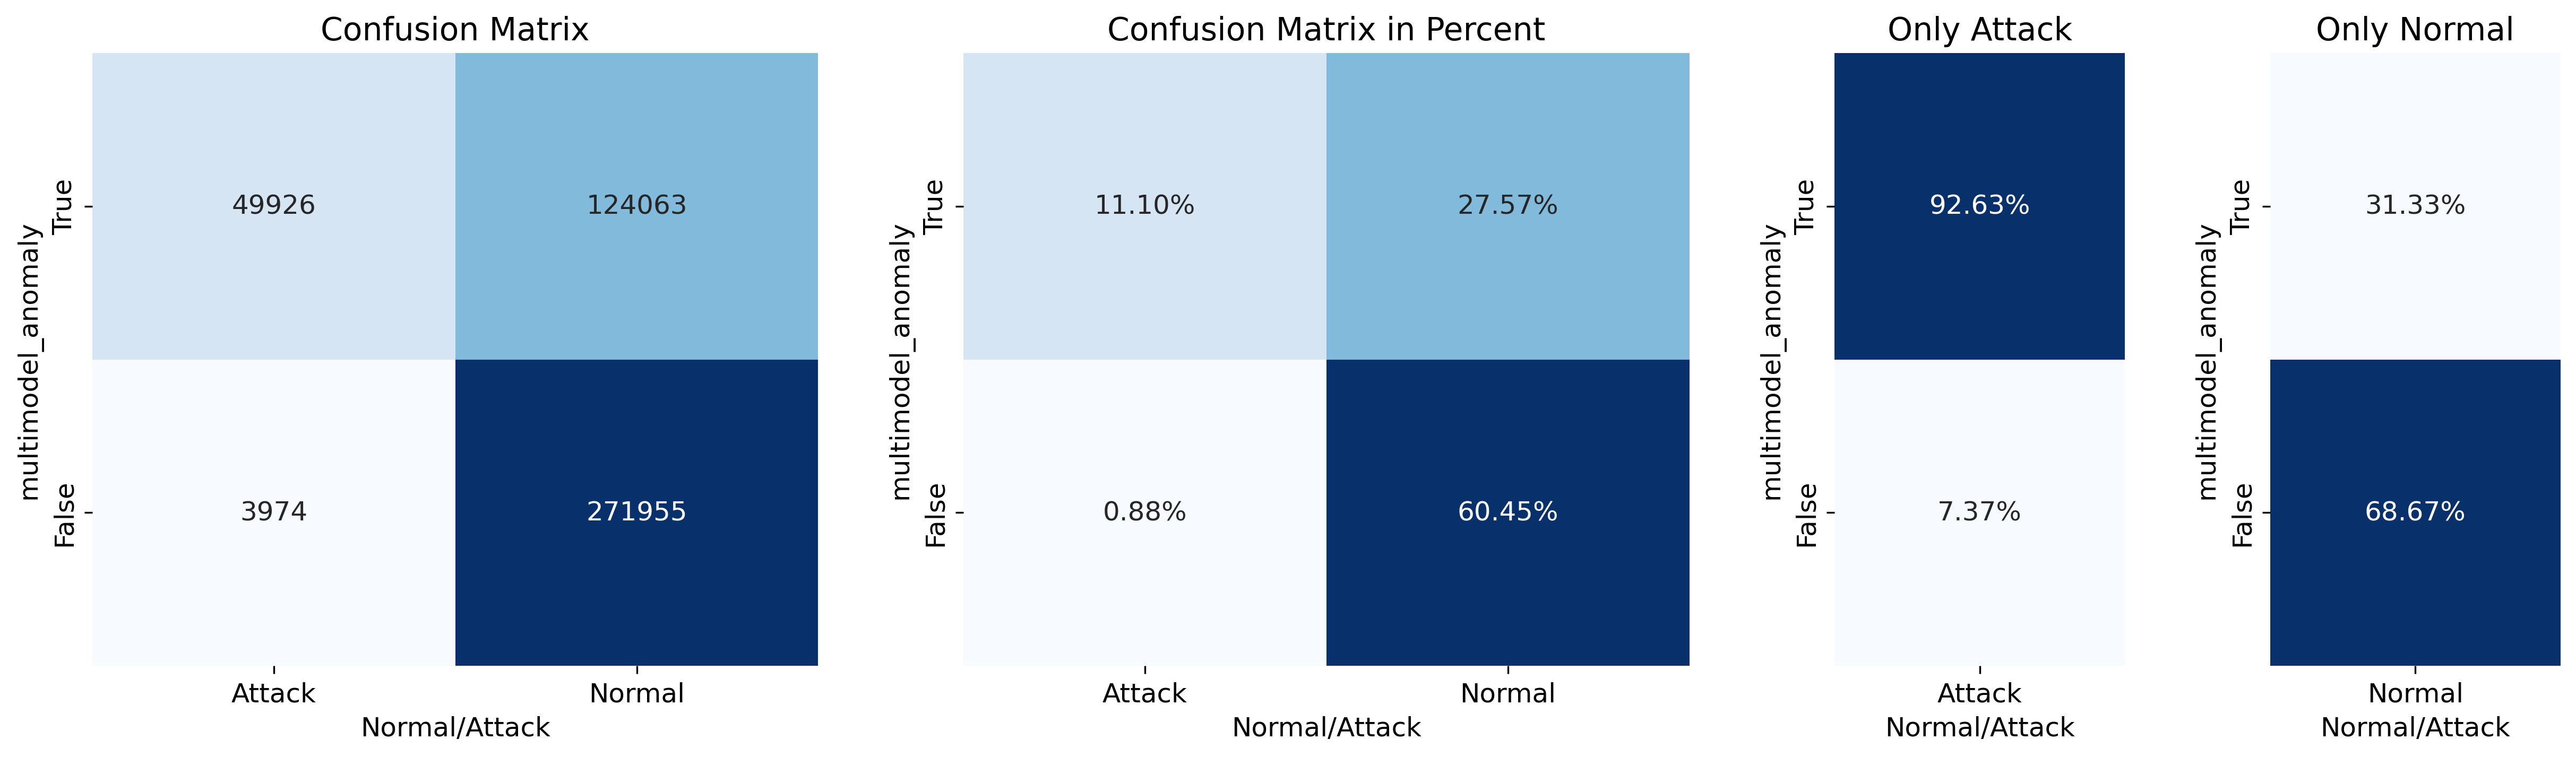

In [294]:
df_cyclic_train, df_cyclic_test = get_train_test_dataset(df_cyclic)

fig = plt.figure(figsize=(20, 5), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(1, 6)

plt.rcParams.update({'font.size': 12})

# add a subplot to the figure with 1 row and 3 column
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(df_cyclic_test[['multimodel_anomaly', 'Normal/Attack']].value_counts().unstack(), annot=True, fmt="d", ax=ax1, cmap='Blues', cbar=False)
ax1.set_title('Confusion Matrix')
ax1.invert_yaxis()

# add a subplot to the figure with 1 row and 3 column
ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(df_cyclic_test[['multimodel_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax2, cmap='Blues', cbar=False)
ax2.set_title('Confusion Matrix in Percent')
ax2.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[0, 4:5])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Attack']
sns.heatmap(df_cyclic_test_attack[['multimodel_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax3, cmap='Blues', cbar=False)
ax3.set_title('Only Attack')
ax3.invert_yaxis()

# add a subplot to the figure with 1 row and 1 column 
ax4 = fig.add_subplot(gs[0, 5:6])
df_cyclic_test_attack = df_cyclic_test[df_cyclic_test['Normal/Attack'] == 'Normal']
sns.heatmap(df_cyclic_test_attack[['multimodel_anomaly', 'Normal/Attack']].value_counts(normalize=True).unstack(), annot=True, fmt=".2%", ax=ax4, cmap='Blues', cbar=False)
ax4.set_title('Only Normal')
ax4.invert_yaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)

## Delay of detection for each attack

In [ ]:

attacks = list(df_cyclic['attack'].unique())
attacks.remove(0)

df_attack_detected = pd.DataFrame()
for attack in attacks:
    df_attack = df_cyclic[df_cyclic['attack'] == attack]
    
    df_detected = pd.DataFrame({
        'attack': [attack],
        'duration_attack': [len(df_attack)],
        })
    for model in ['min_max_anomaly', 'state_not_detected', 'longest_slope_anomaly', 'anomaly_discrete_LS', 'anomaly_var_zero', 'multimodel_anomaly',]:
        delay = (df_attack[df_attack[model] == 1]['Timestamp'].min() - df_attack['Timestamp'].min()).total_seconds()
        counts_detected = len(df_attack[df_attack[model] == 1])
        counts_not_detected = len(df_attack[df_attack[model] == 0])
        model = model.replace('_not_detected', '_anomaly')
        df_detected = pd.concat(objs=[df_detected, pd.DataFrame({f'{model}_detected': [counts_detected], f'{model}_not_detected': [counts_not_detected], f'{model}_delay': [delay]})], axis=1)
        
    df_attack_detected = pd.concat(objs=[df_attack_detected, df_detected], axis=0)

In [143]:
col_keep = ['attack', 'duration_attack', 'min_max_anomaly_delay', 'state_anomaly_delay', 'longest_slope_anomaly_delay', 'anomaly_discrete_LS_delay', 'anomaly_var_zero_delay', 'multimodel_anomaly_delay']

matrix = df_attack_detected[col_keep]
matrix.columns = ['attack', 'duration_attack', 'min_max_anomaly_delay', 'state_anomaly_delay', 'longest_slope_anomaly_delay', 'anomaly_discrete_LS_delay', 'anomaly_var_zero_delay', 'multimodel_anomaly_delay']
matrix = matrix.sort_values(by='duration_attack', ascending=False)
matrix = matrix.T
matrix.columns = matrix.iloc[0]
matrix = matrix.drop(matrix.index[0])
# matrix.columns = df_attack_detected['attack'].unique()
matrix = matrix.T

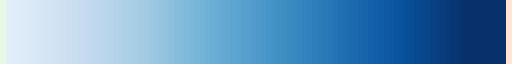

In [210]:

from matplotlib.colors import ListedColormap
import matplotlib
# create a colormap from the list of colors from white to the color blue

flatui = []

# add 20 time the color green nuance
for i in range(0, 1):
    percent = 0.1 + (i * 0.01)
    color = sns.color_palette("Greens", as_cmap=True)(percent)
    hex_cp = matplotlib.colors.to_hex(color)
    flatui.append(hex_cp)
    

for i in range(0, 98):
    percent = 0.1 + (i * 0.01)
    color = sns.color_palette("Blues", as_cmap=True)(percent)
    hex_cp = matplotlib.colors.to_hex(color)
    flatui.append(hex_cp)
    

for i in range(0, 1):
    percent = 0.1 + (i * 0.01)
    color = sns.color_palette("Reds", as_cmap=True)(percent)
    hex_cp = matplotlib.colors.to_hex(color)
    flatui.append(hex_cp)
    
delay_cmap = ListedColormap(sns.color_palette(flatui).as_hex())
delay_cmap

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_23337/750308537.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_delay[col] = matrix_delay[col] / matrix_duration['duration_attack']


[Text(0.5, 1, 'duration_attack')]

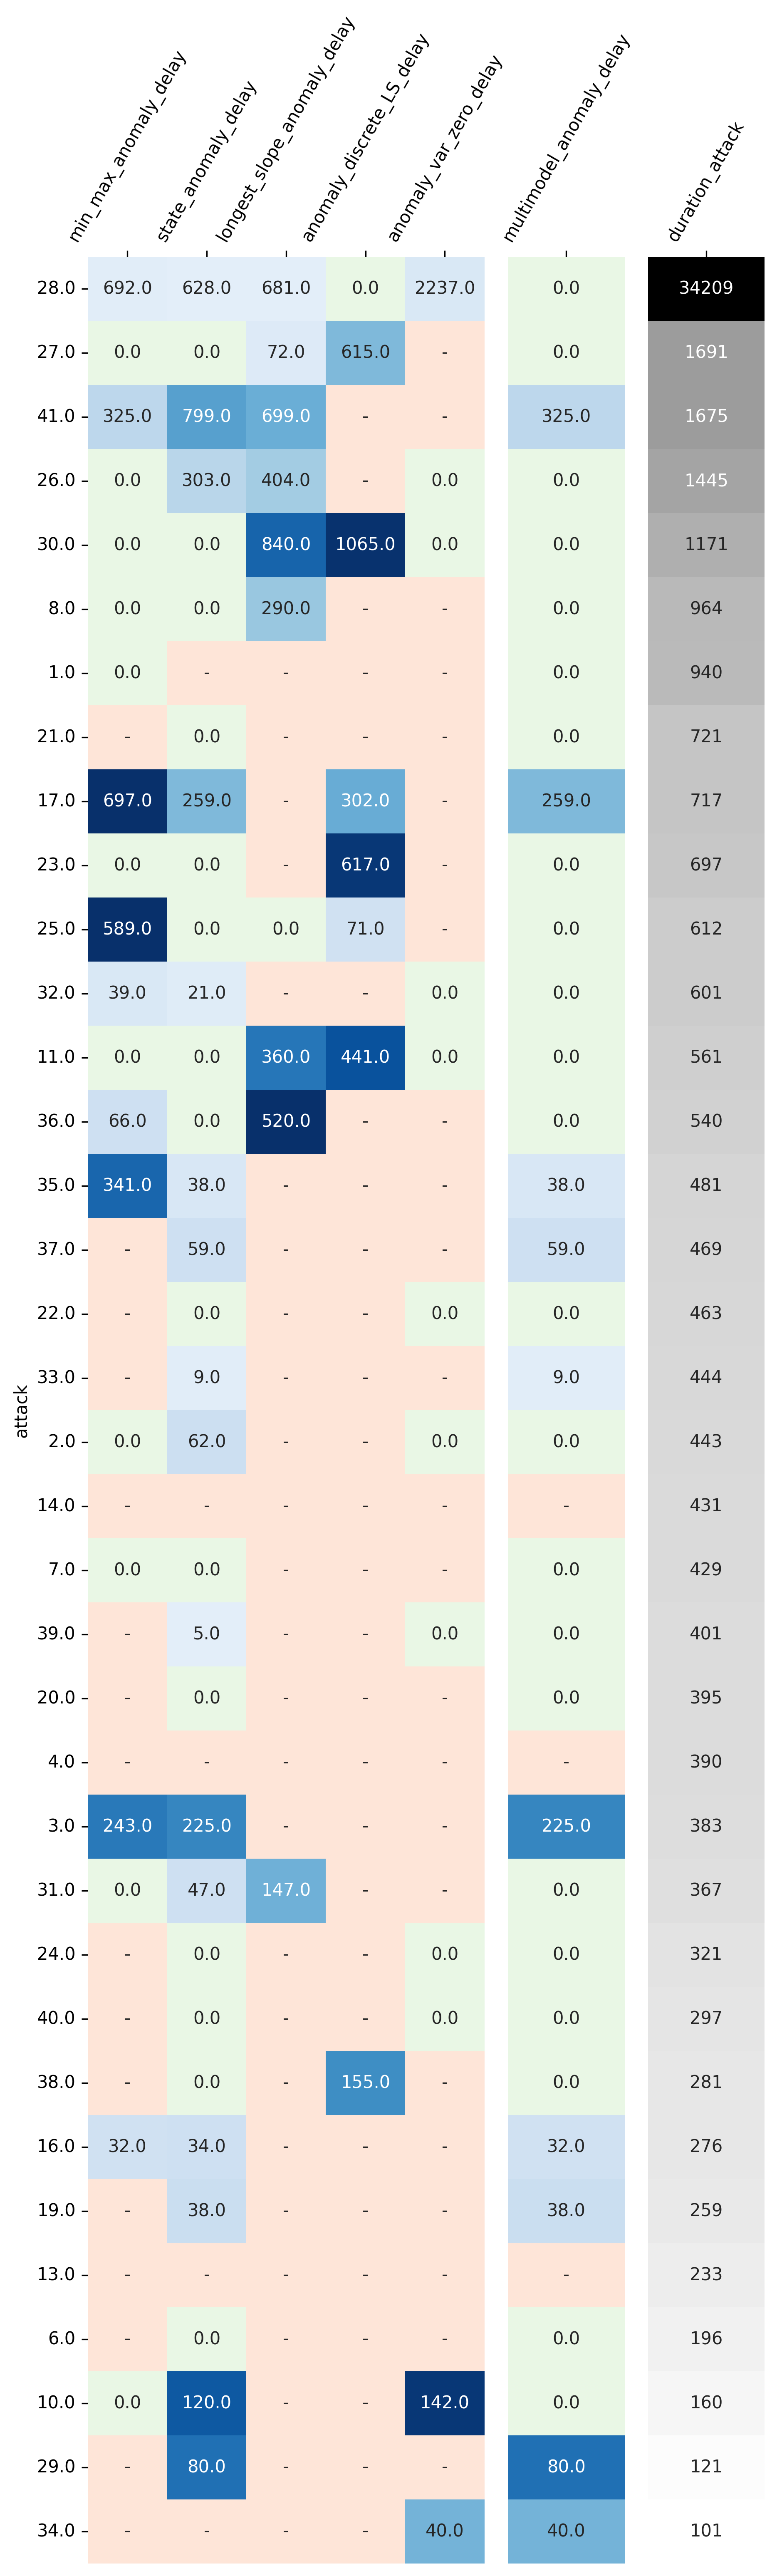

In [224]:
from matplotlib.colors import LogNorm

matrix_duration = matrix['duration_attack'].to_frame()
matrix_delay = matrix[['min_max_anomaly_delay', 'state_anomaly_delay', 'longest_slope_anomaly_delay', 'anomaly_discrete_LS_delay', 'anomaly_var_zero_delay', 'multimodel_anomaly_delay']]


fig = plt.figure(figsize=(7, 24), dpi=300)
# make a grid with 1 row and 5 columns
gs = fig.add_gridspec(1, 5)

matrix_delay_str = matrix_delay.fillna('-')

labels_multimodel = np.array(matrix_delay_str['multimodel_anomaly_delay'].to_frame())
labels = np.array(matrix_delay_str[['min_max_anomaly_delay', 'state_anomaly_delay', 'longest_slope_anomaly_delay', 'anomaly_discrete_LS_delay', 'anomaly_var_zero_delay']])

for col in matrix_delay.columns:
    matrix_delay[col] = matrix_delay[col] / matrix_duration['duration_attack']
matrix_delay = matrix_delay.fillna(1)

matrix_delay_multimodel = matrix_delay['multimodel_anomaly_delay'].to_frame()
matrix_delay = matrix_delay[['min_max_anomaly_delay', 'state_anomaly_delay', 'longest_slope_anomaly_delay', 'anomaly_discrete_LS_delay', 'anomaly_var_zero_delay']]

# add a subplot with 1 column and 1 rows
ax1 = fig.add_subplot(gs[0, 0:3])
sns.heatmap(matrix_delay, cmap=delay_cmap, annot=labels, fmt='', ax=ax1, cbar=False)

ax1.xaxis.tick_top()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

ax2 = fig.add_subplot(gs[0, 3:4])
sns.heatmap(matrix_delay_multimodel, cmap=delay_cmap, annot=labels_multimodel, fmt='', ax=ax2, cbar=False)

ax2.xaxis.tick_top()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
ax2.yaxis.set_visible(False)

# add a subplot with 4 column and 1 rows
ax3 = fig.add_subplot(gs[0, 4:5])
sns.heatmap(matrix_duration, annot=True, fmt='g', ax=ax3, cmap='Greys', cbar=False, norm=LogNorm())
ax3.yaxis.set_visible(False)
ax3.xaxis.tick_top()
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=60)


In [48]:
# calculate the percentage of detected and not detected
for model in ['min_max_anomaly', 'state_anomaly', 'longest_slope_anomaly', 'anomaly_discrete_LS', 'anomaly_var_zero', 'multimodel_anomaly',]:
    df_attack_detected[f'{model}_detected_%'] = np.round(df_attack_detected[f'{model}_detected'] / df_attack_detected['duration_attack'], 2) * 100
    df_attack_detected[f'{model}_not_detected_%'] = np.round(df_attack_detected[f'{model}_not_detected'] / df_attack_detected['duration_attack'], 2) * 100
col_keep = ['attack', 'duration_attack']
for col in df_attack_detected.columns:
    if '%' in col and 'not_' not in col:
        col_keep.append(col)
matrix = df_attack_detected[col_keep]
matrix.columns = ['attack', 'duration_attack', 'min_max_anomaly', 'state_anomaly', 'longest_slope_anomaly', 'anomaly_discrete_LS', 'anomaly_var_zero', 'multimodel_anomaly']
matrix = matrix.sort_values(by='duration_attack')
matrix = matrix.T
matrix.columns = matrix.iloc[0]
matrix = matrix.drop(matrix.index[0])
# matrix.columns = df_attack_detected['attack'].unique()
matrix

attack                  34.0   29.0   10.0   6.0    13.0   19.0   16.0   38.0  \
duration_attack        101.0  121.0  160.0  196.0  233.0  259.0  276.0  281.0   
min_max_anomaly          0.0    0.0  100.0    0.0    0.0    0.0   83.0    0.0   
state_anomaly            0.0   34.0   25.0   90.0    0.0    8.0   88.0   65.0   
longest_slope_anomaly    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
anomaly_discrete_LS      0.0    0.0    0.0    0.0    0.0    0.0    0.0   16.0   
anomaly_var_zero        60.0    0.0   11.0    0.0    0.0    0.0    0.0    0.0   
multimodel_anomaly      60.0   34.0  100.0   90.0    0.0    8.0   88.0   74.0   

attack                  40.0   24.0   31.0   3.0    4.0    20.0   39.0   7.0   \
duration_attack        297.0  321.0  367.0  383.0  390.0  395.0  401.0  429.0   
min_max_anomaly          0.0    0.0  100.0   31.0    0.0    0.0    0.0  100.0   
state_anomaly          100.0   10.0   87.0   41.0    0.0   14.0   27.0   27.0   
longest_slope_anomaly    0.0    0.0   27.0    0.0    0.0    0.0    0.0    0.0   
anomaly_discrete_LS      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
anomaly_var_zero       100.0   17.0    0.0    0.0    0.0    0.0  100.0    0.0   
multimodel_anomaly     100.0   27.0  100.0   41.0    0.0   14.0  100.0  100.0   

attack                  14.0   2.0    33.0   22.0   37.0   35.0   36.0   11.0  \
duration_attack        431.0  443.0  444.0  463.0  469.0  481.0  540.0  561.0   
min_max_anomaly          0.0   98.0    0.0    0.0    0.0   29.0   88.0   10.0   
state_anomaly            0.0   61.0   66.0  100.0   87.0   22.0  100.0  100.0   
longest_slope_anomaly    0.0    0.0    0.0    0.0    0.0    0.0    4.0   18.0   
anomaly_discrete_LS      0.0    0.0    0.0    0.0    0.0    0.0    0.0   16.0   
anomaly_var_zero         0.0   95.0    0.0   96.0    0.0    0.0    0.0   97.0   
multimodel_anomaly       0.0   98.0   66.0  100.0   87.0   51.0  100.0  100.0   

attack                  32.0   25.0   23.0   17.0   21.0   1.0    8.0   \
duration_attack        601.0  612.0  697.0  717.0  721.0  940.0  964.0   
min_max_anomaly         94.0    4.0  100.0    3.0    0.0  100.0  100.0   
state_anomaly           63.0   15.0   29.0   61.0   17.0    0.0   20.0   
longest_slope_anomaly    0.0   80.0    0.0    0.0    0.0    0.0   62.0   
anomaly_discrete_LS      0.0   88.0   11.0   58.0    0.0    0.0    0.0   
anomaly_var_zero         7.0    0.0    0.0    0.0    0.0    0.0    0.0   
multimodel_anomaly     100.0  100.0  100.0   64.0   17.0  100.0  100.0   

attack                   30.0    26.0    41.0    27.0     28.0  
duration_attack        1171.0  1445.0  1675.0  1691.0  34209.0  
min_max_anomaly         100.0   100.0    81.0    32.0     98.0  
state_anomaly             7.0    44.0    18.0     4.0     20.0  
longest_slope_anomaly    17.0    62.0    30.0    89.0     98.0  
anomaly_discrete_LS       5.0     0.0     0.0    64.0    100.0  
anomaly_var_zero         96.0    98.0     0.0     0.0     93.0  
multimodel_anomaly      100.0   100.0    81.0   100.0    100.0

In [49]:
# create a heatmap from the matrix color not based on duration of the attack
matrix.columns = matrix.columns.astype(int)
matrix_percent = matrix
matrix_percent = matrix_percent.drop('duration_attack')
matrix_percent = matrix_percent.drop('multimodel_anomaly')
matrix_duration = matrix.loc['duration_attack'].to_frame().T
matrix_multimodel = matrix.loc['multimodel_anomaly'].to_frame().T

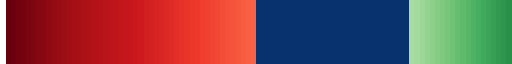

In [51]:

from matplotlib.colors import ListedColormap
import matplotlib
# create a colormap from the list of colors from white to the color blue

flatui = ["#ffffff"]
# add 49 times the color red nuance 
start_percent = 1.00
for i in range(0, 49):
    percent = start_percent - (i * 0.01)
    color = sns.color_palette("Reds", as_cmap=True)(percent)
    hex_cp = matplotlib.colors.to_hex(color)
    flatui.append(hex_cp)
# add 30 times the color blue nuance
for i in range(0, 30):
    flatui.append("#08326e")

# add 20 time the color green nuance
start_percent = 0.75 - 0.02 * 20
for i in range(0, 20):
    percent = start_percent + (i * 0.02)
    color = sns.color_palette("Greens", as_cmap=True)(percent)
    hex_cp = matplotlib.colors.to_hex(color)
    flatui.append(hex_cp)
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())
my_cmap

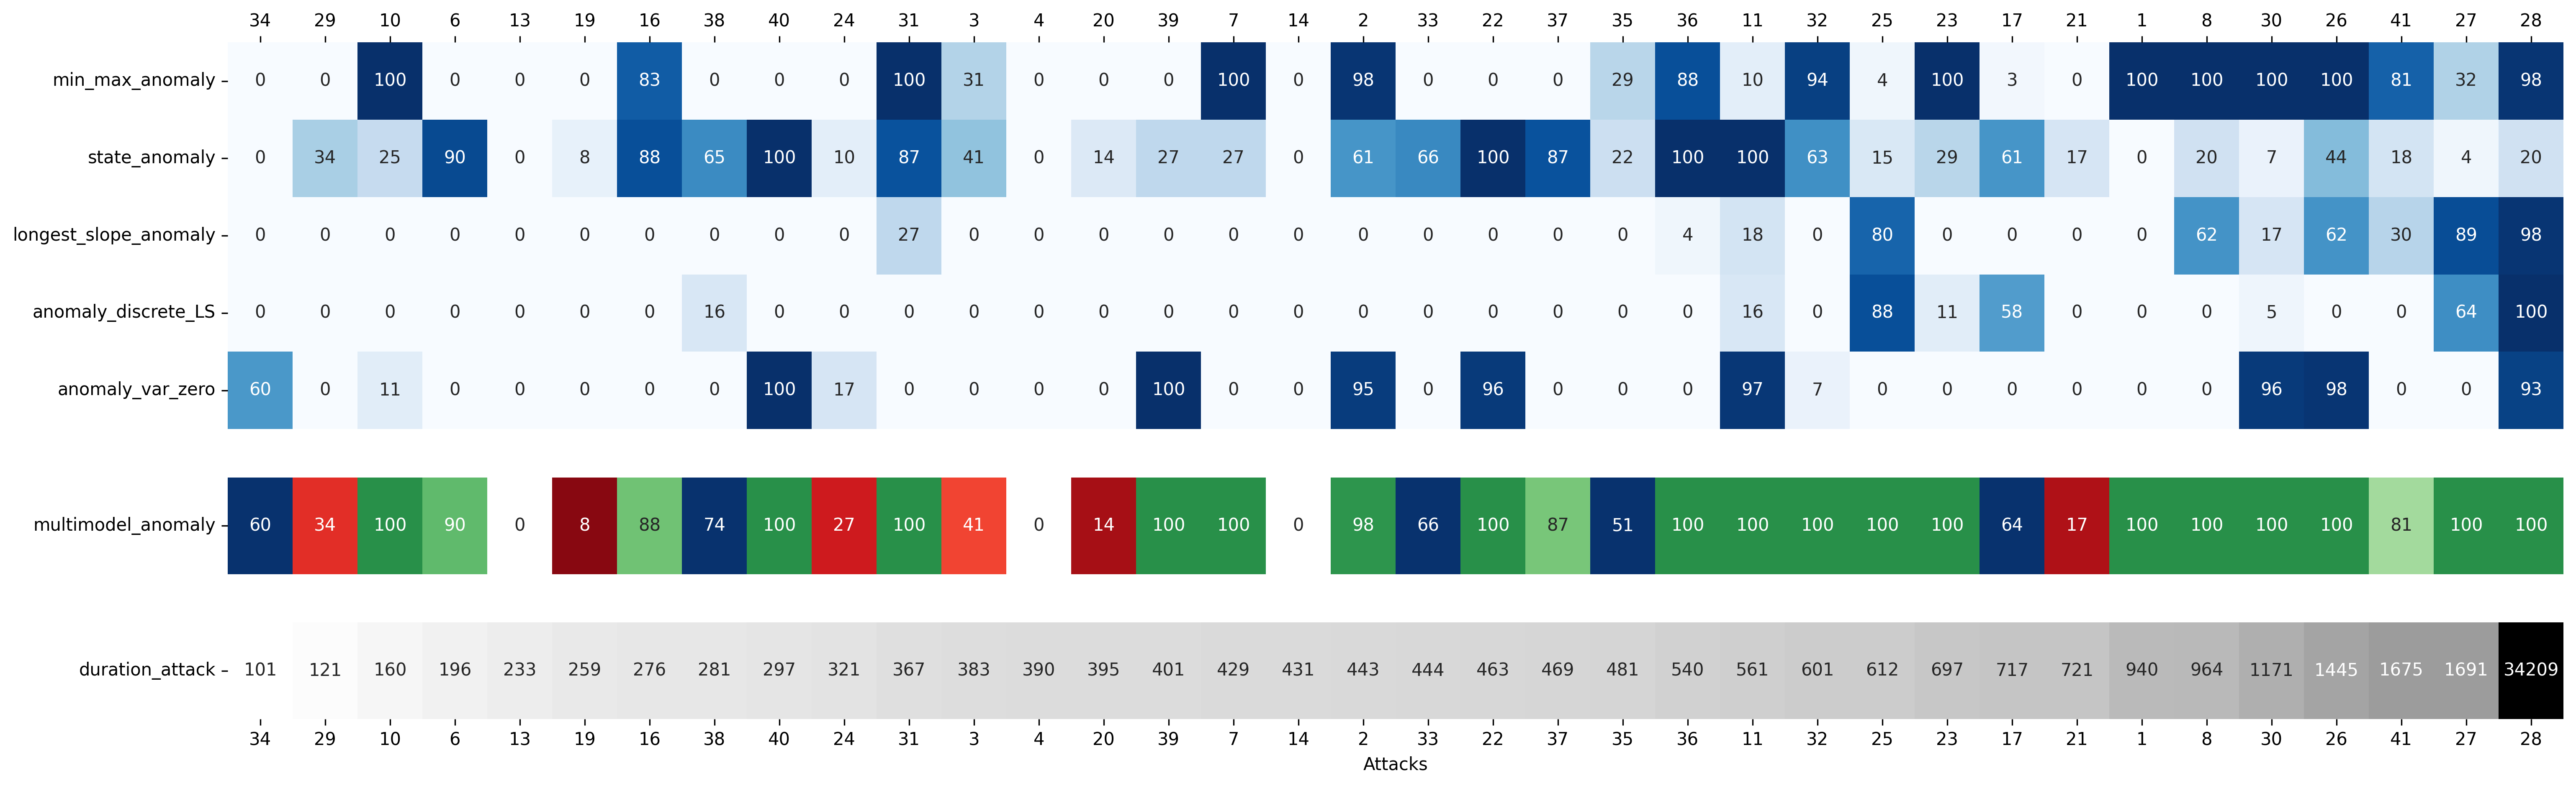

In [52]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(24, 7), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(5, 1)

# add a subplot to the figure with 3 first rows and 1 column
ax1 = fig.add_subplot(gs[0:3,0])
sns.heatmap(matrix_percent, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g', ax=ax1, cbar=False)
# set x-axis on top of the plot
ax1.xaxis.tick_top()
ax1.set_xlabel('')

# add a subplot to the figure with 1 row and 1 column
ax2 = fig.add_subplot(gs[3:4,0])
sns.heatmap(matrix_multimodel, cmap=my_cmap, annot=True, fmt='g', ax=ax2, cbar=False)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
# hide the x axis
ax2.xaxis.set_visible(False)

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[4:5,0])
sns.heatmap(matrix_duration, cmap='Greys', annot=True, fmt='g', ax=ax3, cbar=False, norm=LogNorm())
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0)
ax3.set_xlabel('Attacks')
# change the color of the x axis to the scale of the values

plt.subplots_adjust(hspace=0.5)


In [ ]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(24, 7), dpi=300)
# make plot with 5 rows and 1 column
gs = fig.add_gridspec(5, 1)

# add a subplot to the figure with 3 first rows and 1 column
ax1 = fig.add_subplot(gs[0:3,0])
sns.heatmap(matrix_percent, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g', ax=ax1, cbar=False)
# set x-axis on top of the plot
ax1.xaxis.tick_top()
ax1.set_xlabel('')

# add a subplot to the figure with 1 row and 1 column
ax2 = fig.add_subplot(gs[3:4,0])
sns.heatmap(matrix_multimodel, cmap=my_cmap, annot=True, fmt='g', ax=ax2, cbar=False)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
# hide the x axis
ax2.xaxis.set_visible(False)

# add a subplot to the figure with 1 row and 1 column
ax3 = fig.add_subplot(gs[4:5,0])
sns.heatmap(matrix_duration, cmap='Greys', annot=True, fmt='g', ax=ax3, cbar=False, norm=LogNorm())
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0)
ax3.set_xlabel('Attacks')
# change the color of the x axis to the scale of the values

plt.subplots_adjust(hspace=0.5)
